# Figures 8-11 NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how through the use of SHAP values we can interpret XGBoost models where traditionally only linear models are used. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider this as rock solid medical insights, but rather just as a proof of concept. 

Note that XGBoost only recently got support for a Cox objective, so you will need the most recent version of master.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
import xgboost
import numpy as np
import shap
import scipy as sp
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Create XGBoost data objects

In [13]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True)
X = X.fillna(X.mean())

def sort_data(X, y):
    sinds = np.argsort(np.abs(y))
    return X.iloc[sinds,:],y[sinds]

# create a complete dataset
#X,y = sort_data(X, np.array(y))
xgb_full = xgboost.DMatrix(X.as_matrix(), label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train,y_train = sort_data(X_train, y_train)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
#X_test,y_test = sort_data(X_test, y_test)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [117]:
X,y = shap.datasets.diabetes()
xgb_full = xgboost.DMatrix(X.as_matrix(), label=y)

In [262]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 3, 
    "objective": "reg:linear",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 700, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-rmse:162.484
[699]	test-rmse:15.7633


In [185]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1, 
    "objective": "reg:linear",
    "subsample": 0.5
}
model = xgboost.cv(params, xgboost.DMatrix(Xm, y), 1000, verbose_eval=100)
model = xgboost.train(params, xgboost.DMatrix(Xm, y), 300, verbose_eval=100)

[0]	train-rmse:159.492+0.356263	test-rmse:159.484+1.31521
[100]	train-rmse:40.2013+0.430306	test-rmse:45.5337+1.10283
[200]	train-rmse:37.0256+0.367021	test-rmse:44.6589+0.884369
[300]	train-rmse:35.2748+0.368655	test-rmse:44.1852+0.685825
[400]	train-rmse:33.984+0.41772	test-rmse:44.2691+0.486076
[500]	train-rmse:32.8876+0.375039	test-rmse:44.3419+0.319095
[600]	train-rmse:32.0011+0.368756	test-rmse:44.2352+0.43409
[700]	train-rmse:31.2072+0.372827	test-rmse:44.3279+0.054341
[800]	train-rmse:30.5208+0.334139	test-rmse:44.4178+0.0941341
[900]	train-rmse:29.8514+0.345646	test-rmse:44.3249+0.0586733
[999]	train-rmse:29.2486+0.323823	test-rmse:44.4465+0.0470309


In [186]:
shap_values2 = shap.TreeExplainer(model).shap_values(Xm)

[<matplotlib.lines.Line2D at 0x1a16e98400>]

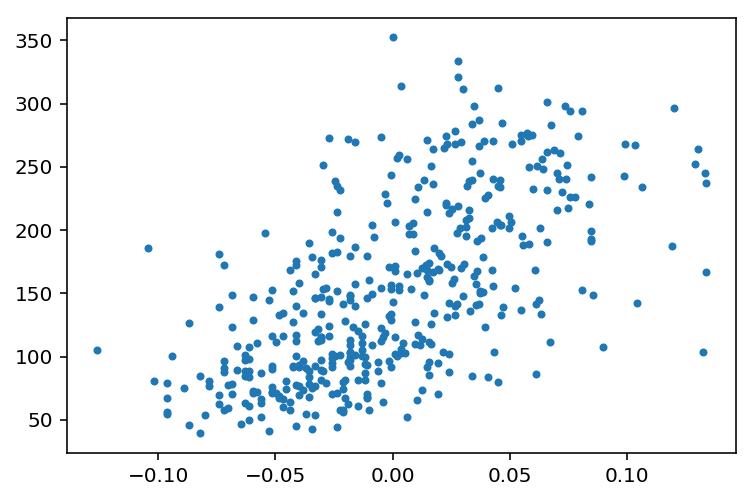

In [195]:
pl.plot(Xm[:,8], y, ".")

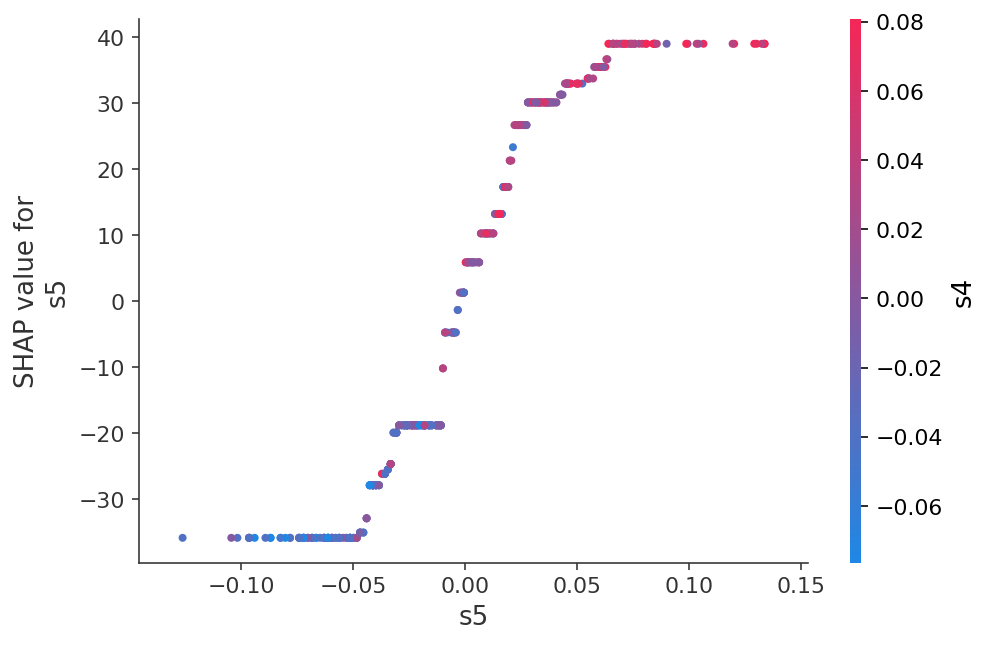

In [192]:
shap.dependence_plot(8, shap_values2, X)

/Users/slund1/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/slund1/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


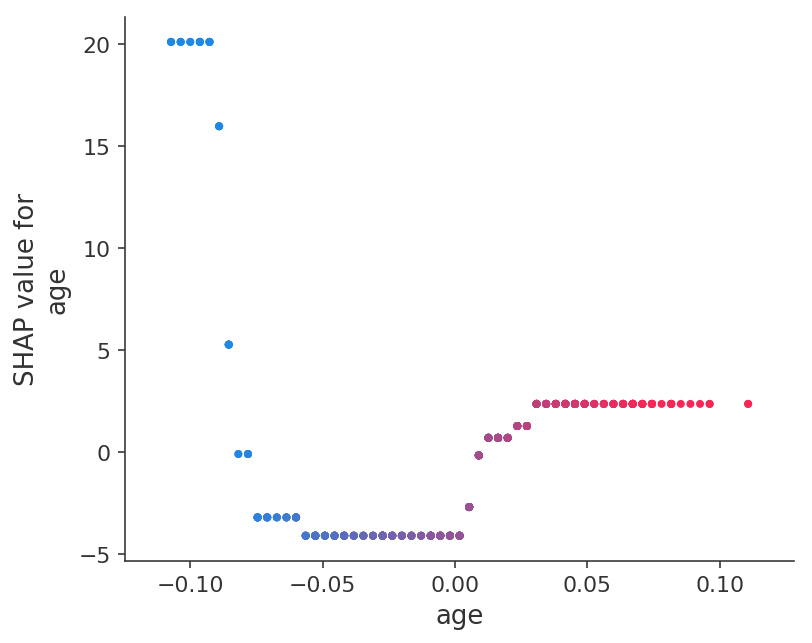

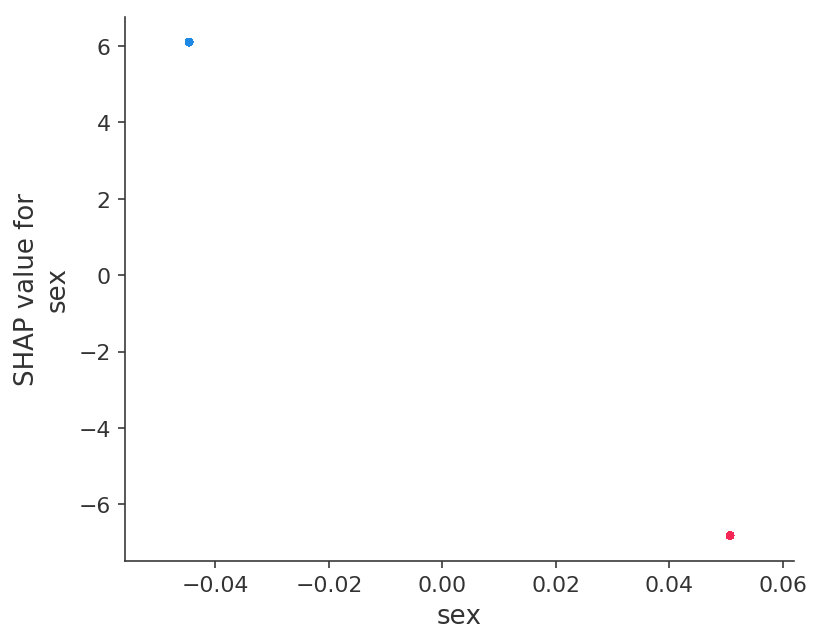

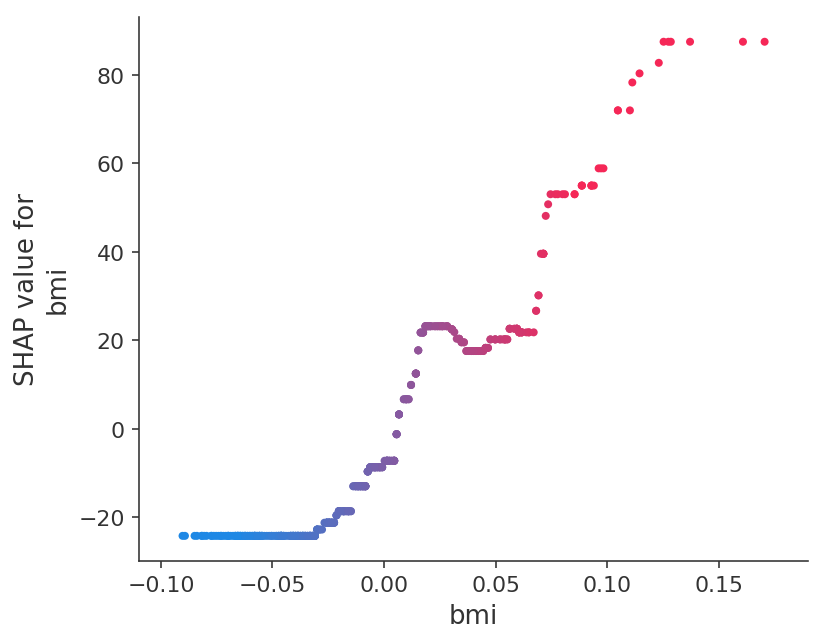

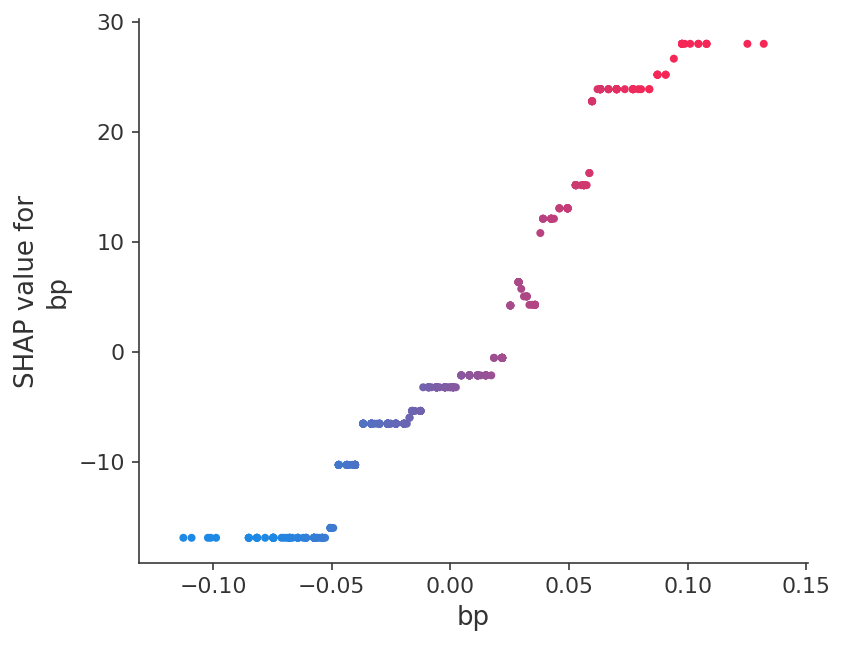

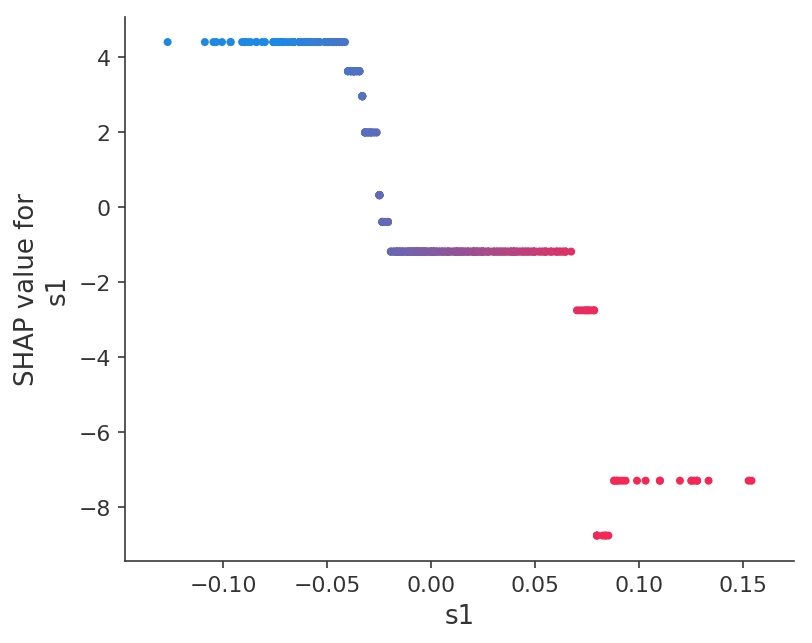

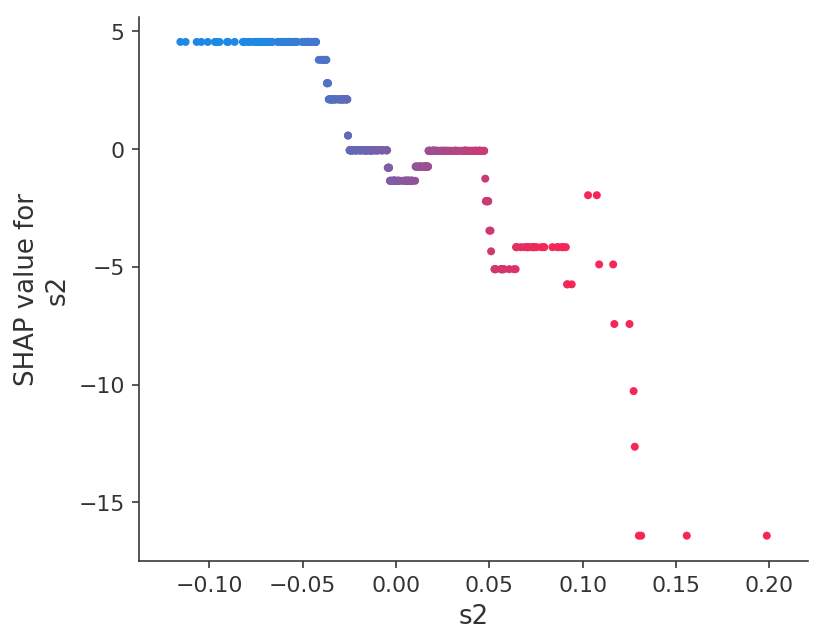

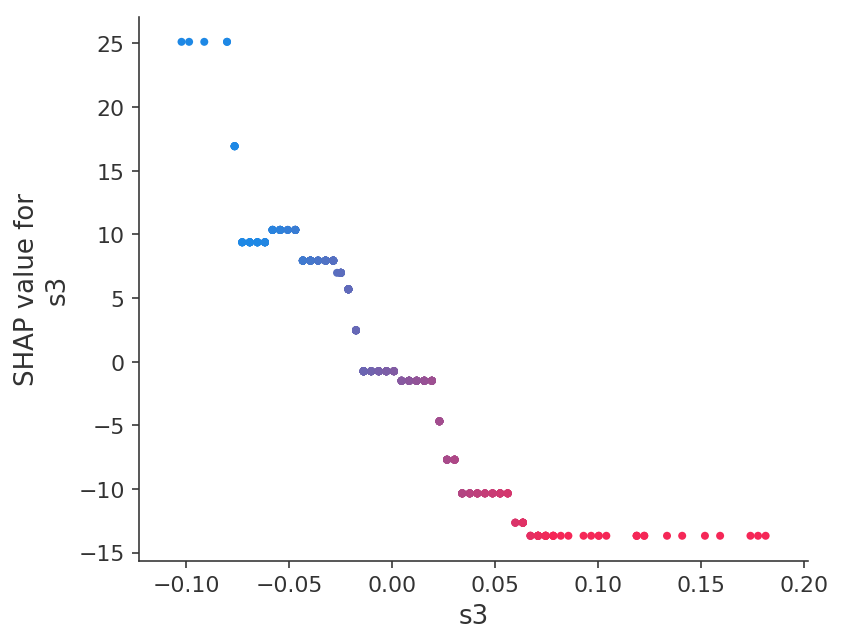

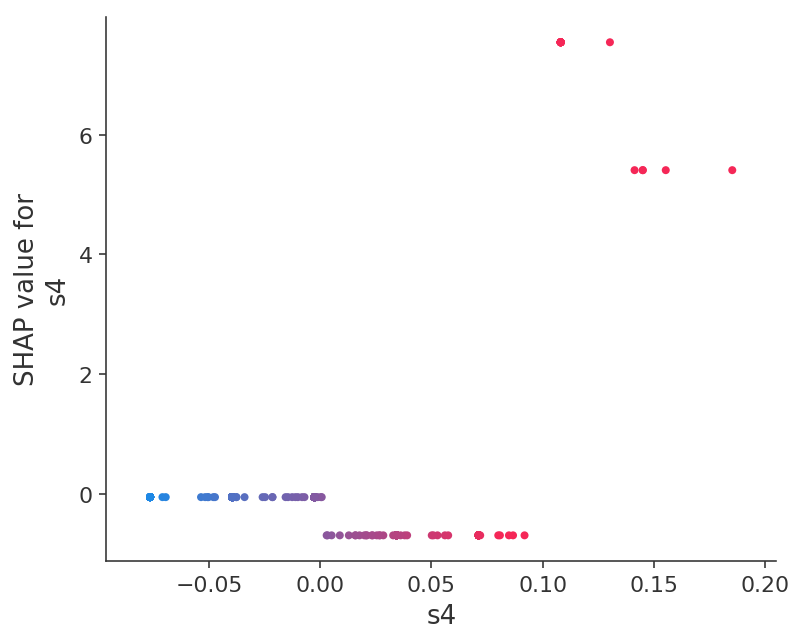

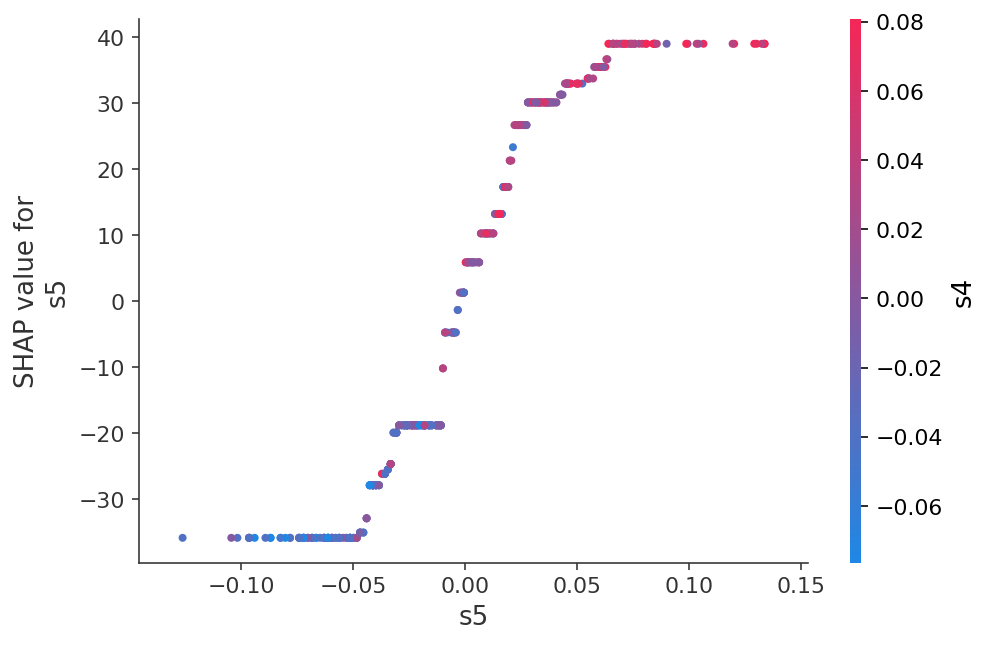

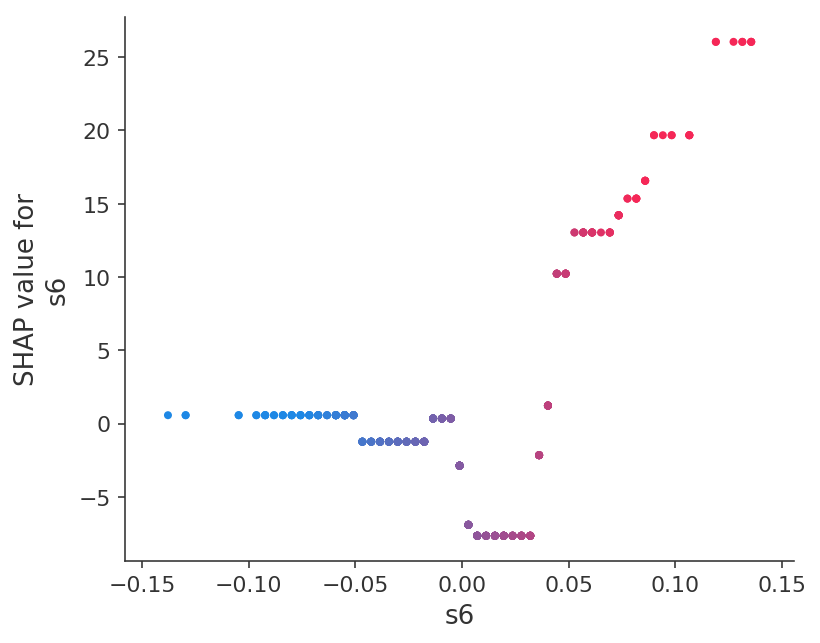

In [190]:
for i in range(X.shape[1]):
    shap.dependence_plot(i, shap_values2, X)





## Train XGBoost model

In [14]:
# use validation set to choose # of trees
# params = {
#     "eta": 0.001,
#     "max_depth": 3,
#     "objective": "survival:cox",
#     "subsample": 0.5
# }
# model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

In [15]:
# train final model on the full data set
params = {
    "eta": 0.001,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 7000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.88223
[1000]	test-cox-nloglik:8.30598
[2000]	test-cox-nloglik:8.17398
[3000]	test-cox-nloglik:8.11941
[4000]	test-cox-nloglik:8.08773
[5000]	test-cox-nloglik:8.06687
[6000]	test-cox-nloglik:8.05102
[6999]	test-cox-nloglik:8.0384


## Explain the predictions on the entire dataset

In [122]:
start = time.time()
shap_values = model.predict(xgb_full, pred_contribs=True)
print(time.time() - start)

0.2779228687286377


In [6]:
shap_values.shape

(9932, 15)

In [16]:
def f(x):
    return model.predict(xgboost.DMatrix(x))

In [ ]:
?shap.force_plot

In [18]:
model.predict(xgboost.DMatrix(np.zeros((1,X.shape[1]))))

array([0.74252933], dtype=float32)

In [19]:
explainer = shap.KernelExplainer(f, np.zeros((1,X.shape[1])))

In [ ]:
explainer = shap.KernelExplainer(f, X.median().as_matrix()[inds[:10],:])

In [31]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
explainer = shap.KernelExplainer(f, X.as_matrix()[inds[:10],:])

In [33]:
6 * X.shape[0]

59592

In [42]:
j = 0
inds = np.arange(X.shape[1])
np.random.shuffle(inds)
np.where(inds == j)[0][0]

3

In [ ]:
inds = np.arange()

In [44]:
[i for i in range(0, 10, 2)]

[0, 2, 4, 6, 8]

In [67]:
def ime(j, f, x, X, nsamples=10):
    assert nsamples % 2 == 0, "nsamples must be divisible by 2!"
    
    X_masked = np.zeros((nsamples, X.shape[1]))
    inds = np.arange(X.shape[1])
    
    for i in range(0, nsamples//2):
        pos = np.where(inds == j)[0][0]
        rind = np.random.randint(X.shape[0])
        X_masked[i,:] = x
        X_masked[i,inds[pos+1:]] = X[rind,inds[pos+1:]]
#         print(i)
#         print(-(i+1))
        X_masked[-(i+1),:] = x
        X_masked[-(i+1),inds[pos:]] = X[rind,inds[pos:]]
#     print(X_masked)
    evals = f(X_masked)
    return np.mean(evals[:nsamples//2] - evals[nsamples//2:])


In [8]:
from iml.common import convert_to_instance, convert_to_model, match_instance_to_data, match_model_to_data, convert_to_instance_with_index
from iml.explanations import AdditiveExplanation
from iml.links import convert_to_link, IdentityLink
from iml.datatypes import convert_to_data, DenseData
import logging
from iml.explanations import AdditiveExplanation

log = logging.getLogger('shap')
from shap import KernelExplainer

In [62]:
import matplotlib.pylab as pl

In [9]:
from shap import KernelExplainer

In [315]:
class IMEExplainer(KernelExplainer):
    """ This is an implementation of the IME explanation method (aka. Shapley sampling values)
    
    This is implemented here for comparision and evaluation purposes, the KernelExplainer is
    typically more efficient and so is the preferred model agnostic estimation method in this package.
    IME was proposed in "An Efficient Explanation of Individual Classifications using Game Theory",
    Erik Štrumbelj, Igor Kononenko, JMLR 2010
    """
    
    def __init__(self, model, data, **kwargs):
        # silence warning about large datasets
        level = log.level
        log.setLevel(logging.ERROR)
        super(IMEExplainer, self).__init__(model, data, **kwargs)
        log.setLevel(level)
    
    def explain(self, incoming_instance, **kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)
        
        # pick a reasonable number of samples if the user didn't specify how many they wanted
        self.nsamples = kwargs.get("nsamples", 0)
        if self.nsamples == 0:
            self.nsamples = 1000 * self.P
        
        # divide up the samples among the features
        self.nsamples_each = np.ones(self.P, dtype=np.int64) * 2 * (self.nsamples // (self.P * 2))
        for i in range((self.nsamples % (self.P * 2)) // 2):
            self.nsamples_each[i] += 2
        
        model_out = self.model.f(instance.x)
        
        # explain every feature
        phi = np.zeros(self.P)
        self.X_masked = np.zeros((self.nsamples_each.max(), X.shape[1]))
        for i in range(self.P):
            phi[i] = self.ime(i, self.model.f, instance.x, self.data.data, nsamples=self.nsamples_each[i])
        phi = np.array(phi)
        
        return AdditiveExplanation(self.link.f(1), self.link.f(1), phi, np.zeros(len(phi)), instance, self.link,
                                   self.model, self.data)
        
        
    def ime(self, j, f, x, X, nsamples=10):
        assert nsamples % 2 == 0, "nsamples must be divisible by 2!"
#         print("nsamples", nsamples, j)
        X_masked = self.X_masked[:nsamples,:]
        inds = np.arange(X.shape[1])

        for i in range(0, nsamples//2):
            np.random.shuffle(inds)
            pos = np.where(inds == j)[0][0]
            rind = np.random.randint(X.shape[0])
            X_masked[i,:] = x
            X_masked[i,inds[pos+1:]] = X[rind,inds[pos+1:]]
            X_masked[-(i+1),:] = x
            X_masked[-(i+1),inds[pos:]] = X[rind,inds[pos:]]
            
        evals = f(X_masked)
        
        evals_on = evals[:nsamples//2]
        evals_off = evals[nsamples//2:][::-1]
#         if j == 0:
#             print(evals)
#             print(np.vstack((X_masked[:,0], evals)).T)
#             print(np.mean(evals[:nsamples//2] - evals[nsamples//2:]))
#             print(evals_on - evals_off)
        return np.mean(evals[:nsamples//2] - evals[nsamples//2:])

In [412]:
class SampleExplainer(KernelExplainer):
    """ 
    """
    
    def __init__(self, model, data, **kwargs):
        # silence warning about large datasets
        level = log.level
        log.setLevel(logging.ERROR)
        super(SampleExplainer, self).__init__(model, data, **kwargs)
        log.setLevel(level)
        
        self.model_null = np.mean(self.model.f(self.data.data))
    
    def explain(self, incoming_instance, **kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)
        
        # pick a reasonable number of samples if the user didn't specify how many they wanted
        self.nsamples = kwargs.get("nsamples", 0)
        if self.nsamples == 0:
            self.nsamples = 1000 * self.P
        
        model_out = self.model.f(instance.x)
        
        # explain every instance
        phi = np.zeros(self.P)
        self.X_masked = np.zeros((self.nsamples, X.shape[1]))
        self.X_mask = np.zeros((self.nsamples+1, X.shape[1]))
        #print(instance.x)
        size_weights = np.array([(self.P - 1)/(s * (self.P - s)) for s in range(1,self.P)])
        size_weights /= size_weights.sum()
        for i in range(self.nsamples):
            # choose size of the subset
            s = np.random.choice(len(size_weights), 1, p=size_weights) + 1

            # choose subset
            S = np.random.choice(M, s, replace=False)

            rind = np.random.randint(self.data.data.shape[0])
            #print(rind)
            self.X_masked[i,:] = self.data.data[rind,:]
            self.X_masked[i,S] = instance.x[0,S]
            self.X_mask[i,S] = 1
        
        y = np.zeros(self.nsamples+1)
        y[:-1] = self.model.f(self.X_masked)
        self.X_mask[-1,:] = 1
        y[-1] = self.model.f(instance.x)[0]
        y -= self.model_null
        #print(y)
        weights = np.ones(self.nsamples + 1) / (self.nsamples * 100)
        weights[-1] = 0.99
        #print(weights.sum())
        
        tmp = (self.X_mask.T * weights)
        phi = np.linalg.inv(tmp @ self.X_mask + np.eye(self.P) * 0.01 / self.nsamples) @ tmp @ y
        #print(phi.sum())
        #print("self.model_null", self.model_null)
        #print(phi)
        return AdditiveExplanation(self.link.f(1), self.link.f(1), phi, np.zeros(len(phi)), instance, self.link,
                                   self.model, self.data)
        
        
#     def ime(self, j, f, x, X, nsamples=10):
#         assert nsamples % 2 == 0, "nsamples must be divisible by 2!"
# #         print("nsamples", nsamples, j)
#         X_masked = self.X_masked[:nsamples,:]
#         inds = np.arange(X.shape[1])

#         for i in range(0, nsamples//2):
#             np.random.shuffle(inds)
#             pos = np.where(inds == j)[0][0]
#             rind = np.random.randint(X.shape[0])
#             X_masked[i,:] = x
#             X_masked[i,inds[pos+1:]] = X[rind,inds[pos+1:]]
#             X_masked[-(i+1),:] = x
#             X_masked[-(i+1),inds[pos:]] = X[rind,inds[pos:]]
            
#         evals = f(X_masked)
        
#         evals_on = evals[:nsamples//2]
#         evals_off = evals[nsamples//2:][::-1]
# #         if j == 0:
# #             print(evals)
# #             print(np.vstack((X_masked[:,0], evals)).T)
# #             print(np.mean(evals[:nsamples//2] - evals[nsamples//2:]))
# #             print(evals_on - evals_off)
#         return np.mean(evals[:nsamples//2] - evals[nsamples//2:])

In [412]:
class SampleExplainer2(KernelExplainer):
    """ 
    """
    
    def __init__(self, model, data, **kwargs):
        # silence warning about large datasets
        level = log.level
        log.setLevel(logging.ERROR)
        super(SampleExplainer, self).__init__(model, data, **kwargs)
        log.setLevel(level)
        
        self.model_null = np.mean(self.model.f(self.data.data))
    
    def explain(self, incoming_instance, **kwargs):
        # convert incoming input to a standardized iml object
        instance = convert_to_instance(incoming_instance)
        match_instance_to_data(instance, self.data)
        
        # pick a reasonable number of samples if the user didn't specify how many they wanted
        self.nsamples = kwargs.get("nsamples", 0)
        if self.nsamples == 0:
            self.nsamples = 1000 * self.P
        
        model_out = self.model.f(instance.x)
        
        # explain every instance
        phi = np.zeros(self.P)
        self.X_masked = np.zeros((self.nsamples, X.shape[1]))
        self.X_mask = np.zeros((self.nsamples+1, X.shape[1]))
        #print(instance.x)
        size_weights = np.array([(self.P - 1)/(s * (self.P - s)) for s in range(1,self.P)])
        size_weights /= size_weights.sum()
        for i in range(self.nsamples):
            # choose size of the subset
            s = np.random.choice(len(size_weights), 1, p=size_weights) + 1

            # choose subset
            S = np.random.choice(M, s, replace=False)

            rind = np.random.randint(self.data.data.shape[0])
            #print(rind)
            self.X_masked[i,:] = self.data.data[rind,:]
            self.X_masked[i,S] = instance.x[0,S]
            self.X_mask[i,S] = 1
        
        y = np.zeros(self.nsamples+1)
        y[:-1] = self.model.f(self.X_masked)
        self.X_mask[-1,:] = 1
        y[-1] = self.model.f(instance.x)[0]
        y -= self.model_null
        #print(y)
        weights = np.ones(self.nsamples + 1) / (self.nsamples * 100)
        weights[-1] = 0.99
        #print(weights.sum())
        
        tmp = (self.X_mask.T * weights)
        phi = np.linalg.inv(tmp @ self.X_mask + np.eye(self.P) * 0.01 / self.nsamples) @ tmp @ y
        #print(phi.sum())
        #print("self.model_null", self.model_null)
        #print(phi)
        return AdditiveExplanation(self.link.f(1), self.link.f(1), phi, np.zeros(len(phi)), instance, self.link,
                                   self.model, self.data)
        
        
#     def ime(self, j, f, x, X, nsamples=10):
#         assert nsamples % 2 == 0, "nsamples must be divisible by 2!"
# #         print("nsamples", nsamples, j)
#         X_masked = self.X_masked[:nsamples,:]
#         inds = np.arange(X.shape[1])

#         for i in range(0, nsamples//2):
#             np.random.shuffle(inds)
#             pos = np.where(inds == j)[0][0]
#             rind = np.random.randint(X.shape[0])
#             X_masked[i,:] = x
#             X_masked[i,inds[pos+1:]] = X[rind,inds[pos+1:]]
#             X_masked[-(i+1),:] = x
#             X_masked[-(i+1),inds[pos:]] = X[rind,inds[pos:]]
            
#         evals = f(X_masked)
        
#         evals_on = evals[:nsamples//2]
#         evals_off = evals[nsamples//2:][::-1]
# #         if j == 0:
# #             print(evals)
# #             print(np.vstack((X_masked[:,0], evals)).T)
# #             print(np.mean(evals[:nsamples//2] - evals[nsamples//2:]))
# #             print(evals_on - evals_off)
#         return np.mean(evals[:nsamples//2] - evals[nsamples//2:])

In [406]:
SampleExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000)

array([ 29.50042062, -11.40049353,   2.82151069,   5.70196048,
         1.11032009,  -3.99864587,  -1.15168281,   3.12895786,
        21.26236444,   6.82550459,   1.        ])

In [ ]:
correct = KernelExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 100000)

In [ ]:
for i in range(10):
    phi1 = SampleExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000)
    phi2 = IMEExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000//2)
#     print("phi1", phi1)
#     print("phi2", phi2)
    
#     print("correct", correct)
    print(np.abs(correct[:-1] - phi1[:-1]).sum())
    print(np.abs(correct[:-1] - phi2[:-1]).sum())
    print()

In [428]:
[IMEExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000)]

array([ 27.87885666, -13.45844936,   5.55445433,   4.80932903,
         1.14691341,   1.13426054,  -3.16114616,   4.27236128,
        22.87189293,   5.88716316,   1.        ])

In [427]:
IMEExplainer(f, Xm).shap_values(Xm[0,:], nsamples = 100)

array([ 13.08285332,   0.        ,  -7.6827774 , -12.1474762 ,
        11.12460327,   0.58374327, -10.23352623,  -1.33031917,
        14.17104816,  -4.96145487,   1.        ])

In [425]:
shap.TreeExplainer(model).shap_values(Xm[0:1,:])

array([[ 16.84768  ,  -6.6394153,   3.9550433,  -6.6007166,   5.766737 ,
         -7.9625177,  -5.5461893,  -3.6230698,  25.030226 ,  -4.920794 ,
        152.15948  ]], dtype=float32)

In [421]:
shap.KernelExplainer(model).shap_values(Xm[0:1,:])

array([[ 16.84768  ,  -6.6394153,   3.9550433,  -6.6007166,   5.766737 ,
         -7.9625177,  -5.5461893,  -3.6230698,  25.030226 ,  -4.920794 ,
        152.15948  ]], dtype=float32)

In [419]:
shap_values[0,:]

array([ 16.84768  ,  -6.6394153,   3.9550433,  -6.6007166,   5.766737 ,
        -7.9625177,  -5.5461893,  -3.6230698,  25.030226 ,  -4.920794 ,
       152.15948  ], dtype=float32)

In [407]:
SampleExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000)

array([ 29.88126608, -13.33655907,   3.85617732,   5.99006771,
        -0.77481879,  -1.61214797,  -4.11244236,   3.5612184 ,
        23.16761429,   7.17800135,   1.        ])

In [417]:
dist_ime = np.array([SampleExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000)[0] for i in range(100)])
dist_ime.std()

1.318006831412146

In [416]:
dist_ime = np.array([IMEExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 1000)[0] for i in range(100)])
dist_ime.std()

0.7913079977893132

In [ ]:
[(M - 1)/(s * (M - s)) for s in range(M+1)]

In [314]:
M = X.shape[1]
size_weights = np.array([(M - 1)/(s * (M - s)) for s in range(1,M)])
size_weights /= size_weights.sum()
for i in range(10):
    # choose size of the subset
    s = np.random.choice(len(size_weights), 1, p=size_weights) + 1
    
    # choose subset
    S = np.random.choice(M, s, replace=False)
    
    rind = np.random.randint(X.shape[0]
    
    print(S)

[8]
[5 2 9 6 3 1 0 7]
[0 3 8 1 6 7 2 4]
[1 0 4 2]
[1 0]
[8 7 9 4 5 0 1 6]
[0 4 9 6 8 1 5 7 2]
[9]
[4 9 0 5 1]
[1 4 8 2 7 5]


In [312]:
len(size_weights),M

M = 
size_weights = np.array([(M - 1)/(s * (M - s)) for s in range(1,M)])

[0, 1, 2, 2.75, 3.33, 3.80555]

(9, 10)

In [303]:
#M = 3
(M - 1)/(M-2)

1.5

In [276]:
dist_ime = np.array([IMEExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 100)[0] for i in range(100)])
dist_ime.std()

2.396391220932111

In [276]:
dist_ime = np.array([IMEExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 100)[0] for i in range(100)])
dist_ime.std()

2.396391220932111

In [415]:
dist_ime = np.array([IMEExplainer(f, Xm).shap_values(Xm[0,:], nsamples = 1000)[0] for i in range(100)])
dist_ime.std()

2.1406455119200576

In [414]:
dist_ime = np.array([SampleExplainer(f, Xm).shap_values(Xm[0,:], nsamples = 1000)[0] for i in range(100)])
dist_ime.std()

3.415270706799702

In [269]:
inds = np.arange(X.shape[0])
n_iter = 100
dist_kernel = np.zeros(n_iter)
for i in range(n_iter):
    np.random.shuffle(inds)
    dist_kernel[i] = KernelExplainer(f, Xm[inds[10:20],:]).shap_values(Xm[0,:], nsamples = 1000)[0]
dist_kernel.std()

4.190238979100308

In [269]:
inds = np.arange(X.shape[0])
n_iter = 100
dist_kernel = np.zeros(n_iter)
for i in range(n_iter):
    np.random.shuffle(inds)
    dist_kernel[i] = KernelExplainer(f, Xm[inds[10:20],:]).shap_values(Xm[0,:], nsamples = 1000)[0]
dist_kernel.std()

4.190238979100308

In [274]:
inds = np.arange(X.shape[0])
n_iter = 100
dist_kernel = np.zeros(n_iter)
for i in range(n_iter):
    #np.random.shuffle(inds)
    dist_kernel[i] = KernelExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 100)[0]
dist_kernel.std()

0.5463016229035879

In [275]:
inds = np.arange(X.shape[0])
n_iter = 100
dist_kernel = np.zeros(n_iter)
for i in range(n_iter):
    np.random.shuffle(inds)
    for j in range(10):
        dist_kernel[i] += KernelExplainer(f, Xm[inds[0]:inds[0]+1,:]).shap_values(Xm[0,:], nsamples = 100)[0]
    dist_kernel[i] /= j
dist_kernel.std()

12.700609891177054

In [282]:
inds = np.arange(X.shape[0])
n_iter = 100
dist_kernel = np.zeros(n_iter)
for i in range(n_iter):
    #np.random.shuffle(inds)
    for j in range(10):
        dist_kernel[i] += IMEExplainer(f, Xm[inds[0]:inds[0]+1,:]).shap_values(Xm[0,:], nsamples = 100)[0]
    dist_kernel[i] /= j
dist_kernel.std()

0.0

In [ ]:
dist_ime = np.array([IMEExplainer(f, np.zeros((1,X.shape[1]))).shap_values(Xm[0,:], nsamples = 100)[0] for i in range(100)])
dist_ime.std()

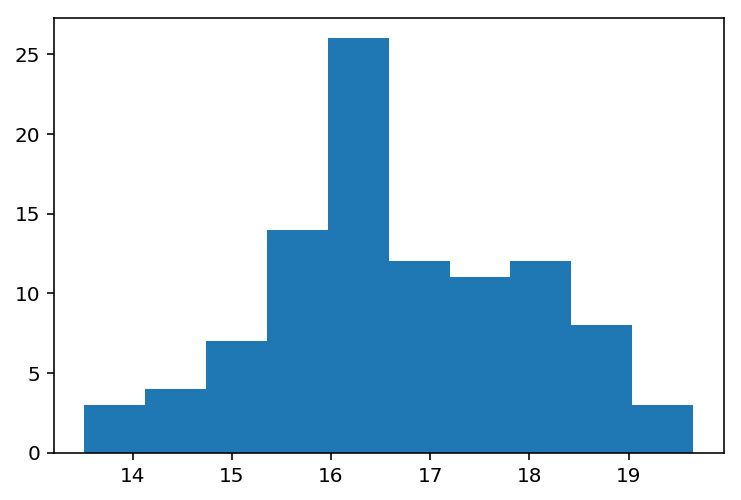

In [150]:
pl.hist(dist)
pl.show()

In [153]:
y = f(X.as_matrix())

np.linalg.inv(X.as_matrix().T @ X.as_matrix()) @ X.as_matrix().T @ (y - y.mean())

array([ -10.71765014, -235.91386568,  521.61137435,  328.50960702,
       -793.76771375,  471.72448606,  110.16841541,  189.45732014,
        745.85134437,   61.34776491])

In [158]:
y = f(X.as_matrix())

Xm = X.as_matrix()
np.linalg.inv(Xm.T @ Xm) @ Xm.T @ (y - 10)

array([ -10.71765014, -235.91386462,  521.61137556,  328.50960671,
       -793.76771221,  471.72448567,  110.16841449,  189.45731992,
        745.85134413,   61.34776354])

In [159]:
np.linalg.inv(Xm.T @ Xm) @ Xm.T @ np.ones(len(y))

array([-1.39208090e-13, -1.01585407e-13, -5.04929432e-13,  3.56381591e-13,
        2.34567921e-12, -1.92557081e-12, -1.18216548e-12,  2.75890422e-13,
       -1.21325172e-12, -1.04360964e-13])

In [161]:
Xm.mean(0)

array([-3.63428493e-16,  1.30834257e-16, -8.04534920e-16,  1.28165452e-16,
       -8.83531559e-17,  1.32702421e-16, -4.57464634e-16,  3.77730150e-16,
       -3.83085422e-16, -3.41288202e-16])

In [120]:
X.iloc[0:1,:]

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.05068,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646


In [169]:
shap_values[3,:]

array([ 6.4392476e+00,  1.4650199e+01, -1.2171090e+01,  5.6450218e-02,
       -2.3872056e+00,  1.1835131e+01,  6.4356194e+00,  3.7722886e+00,
        3.8655327e+01,  2.2799535e+00,  1.5215948e+02], dtype=float32)

In [ ]:
xgboost.

In [173]:
y = f(X.as_matrix())

[<matplotlib.lines.Line2D at 0x1a16c3c9b0>]

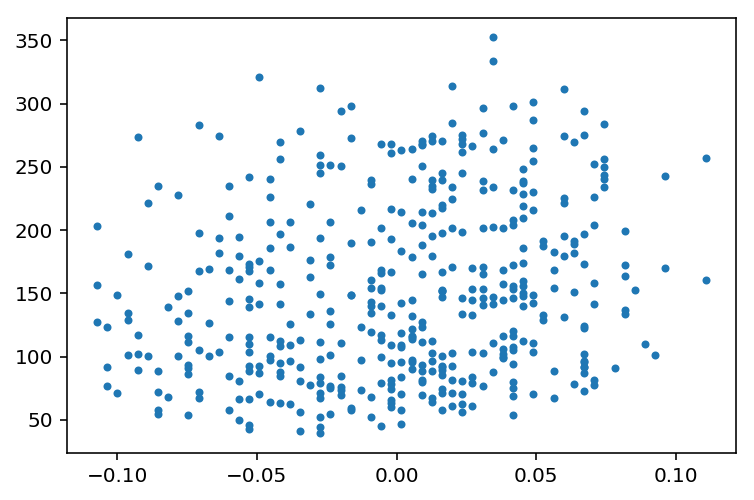

In [175]:
pl.plot(Xm[:,0], y, ".")

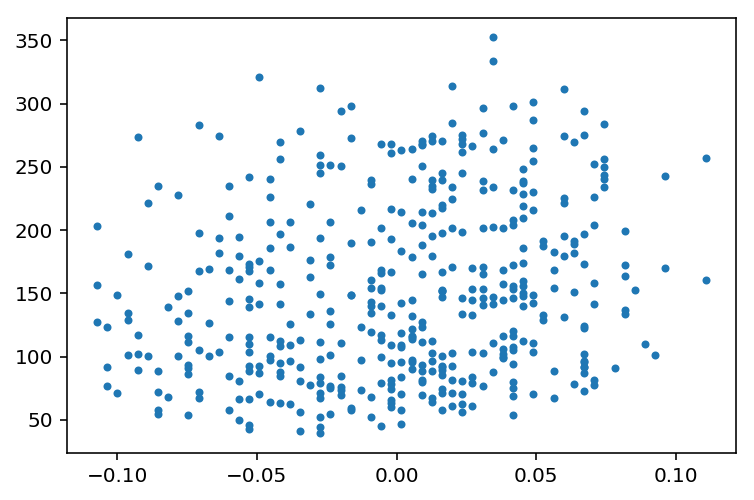

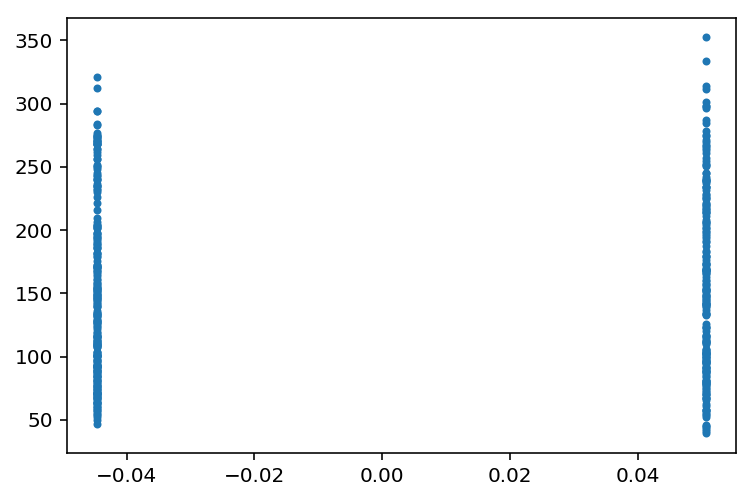

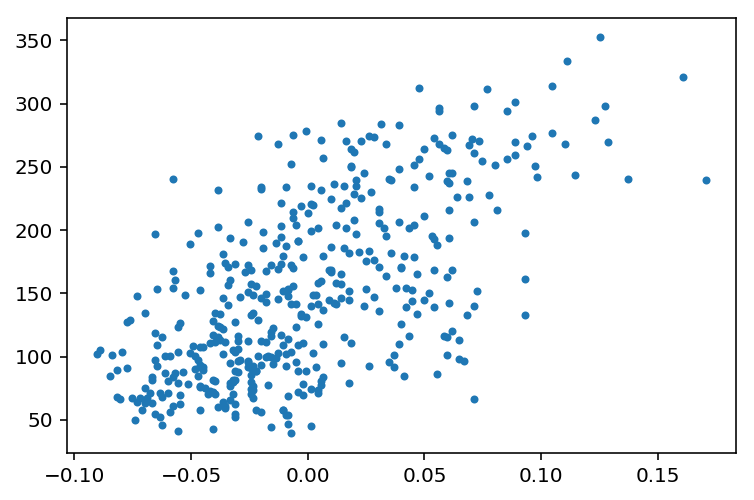

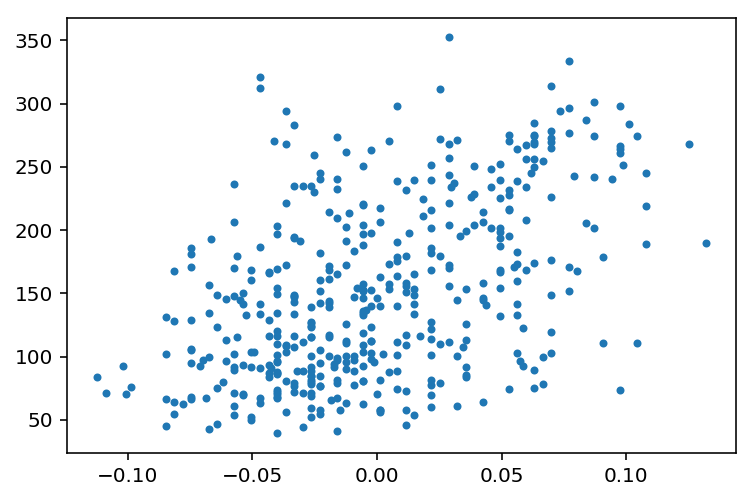

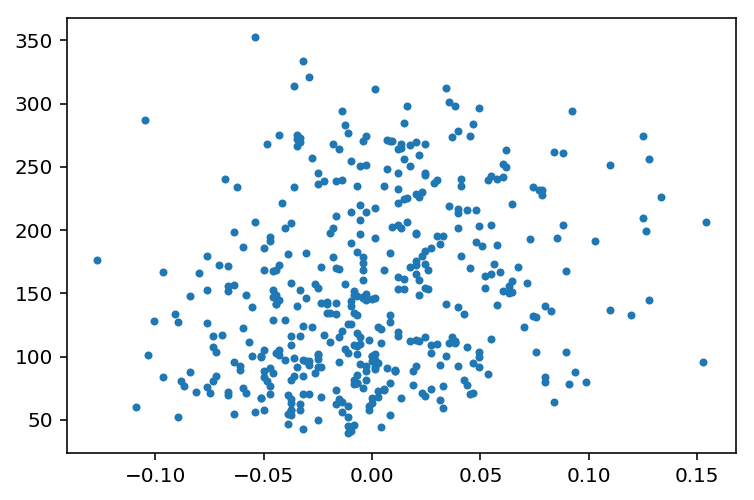

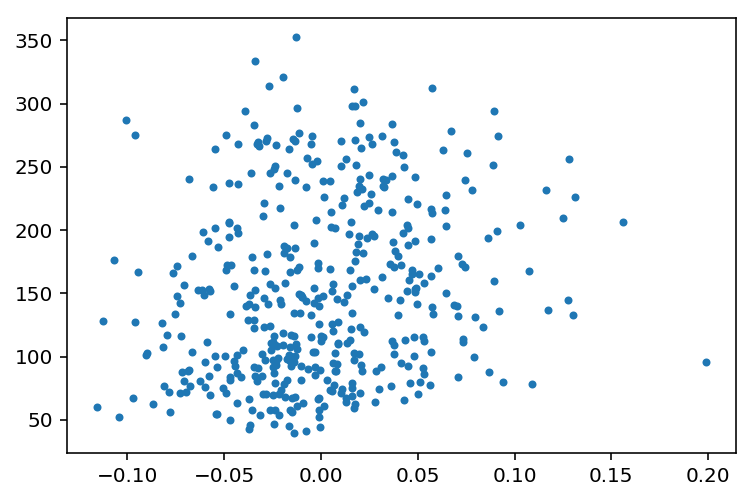

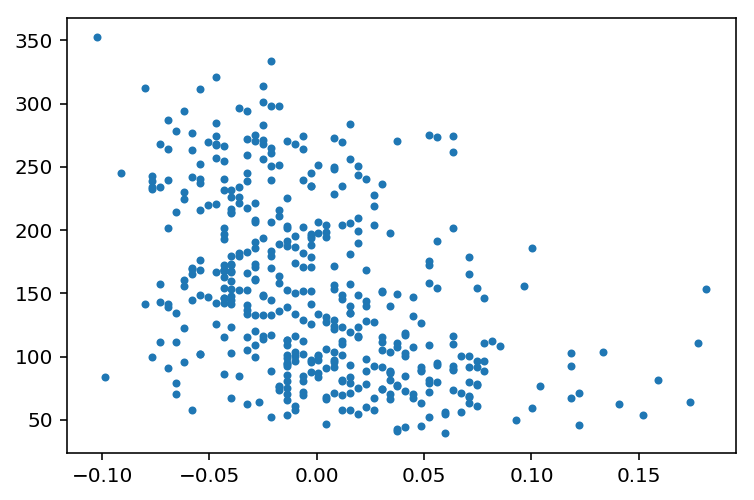

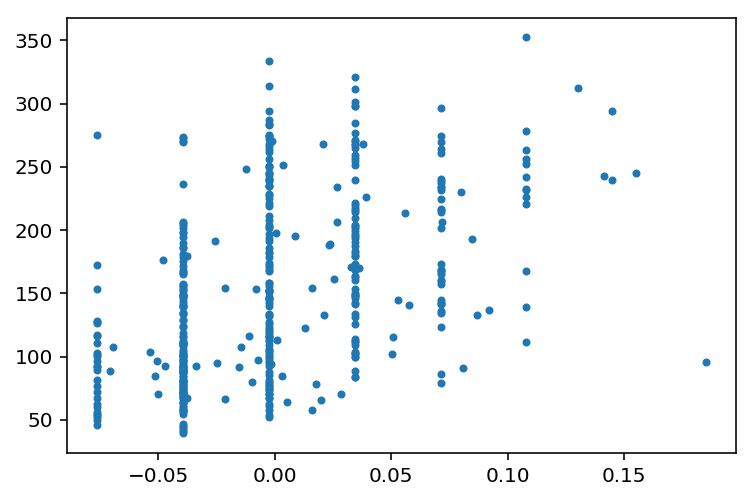

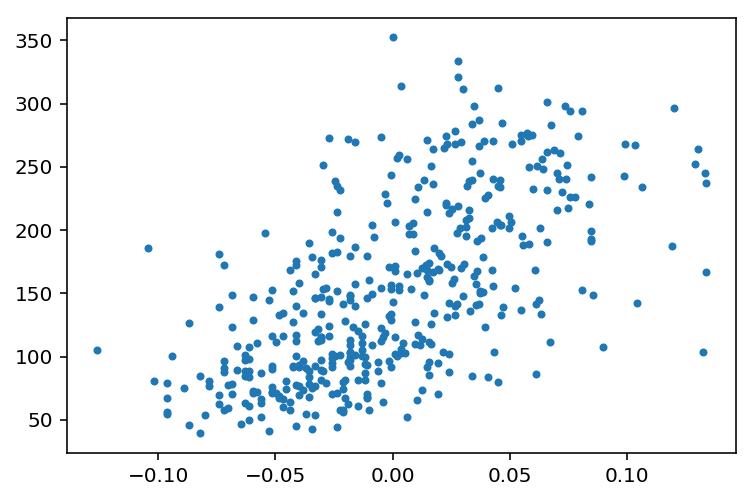

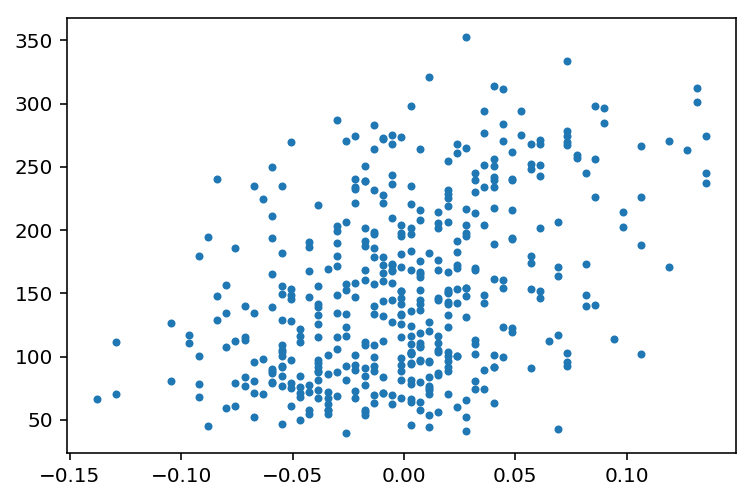

In [177]:
for i in range(X.shape[1]):
    pl.plot(Xm[:,i], y, ".")
    pl.show()

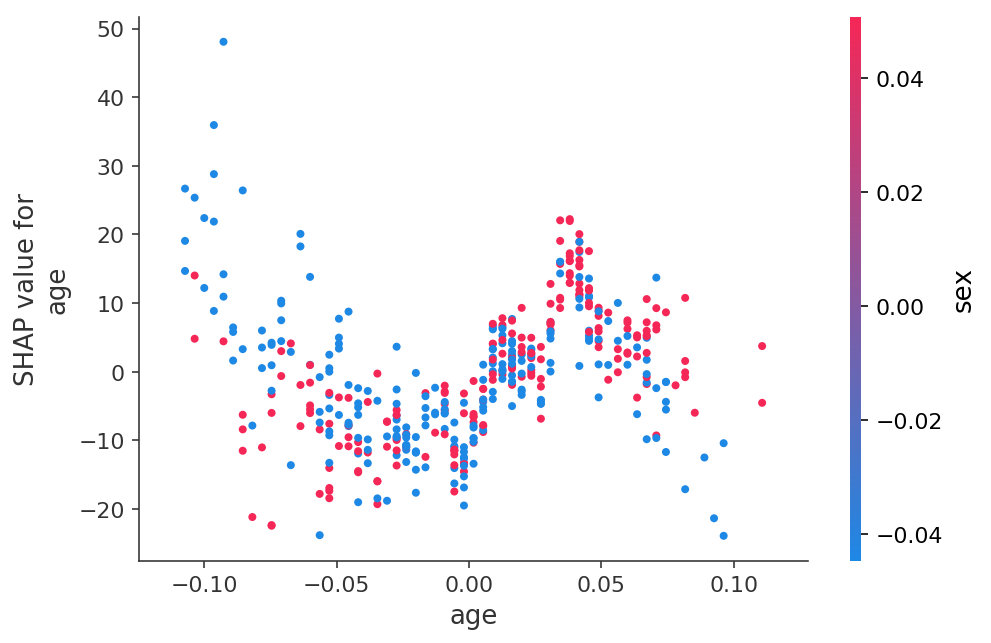

In [110]:
shap.dependence_plot(0, shap_values, X, interaction_index=1)

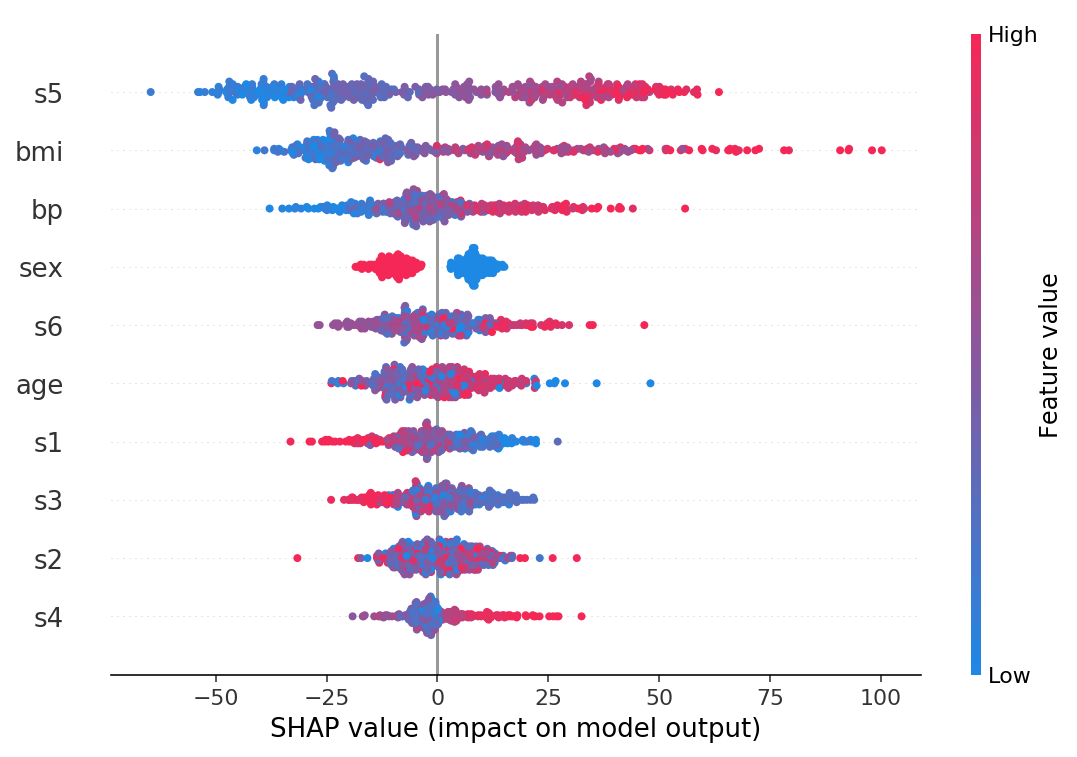

In [163]:
shap.summary_plot(shap_values, X)

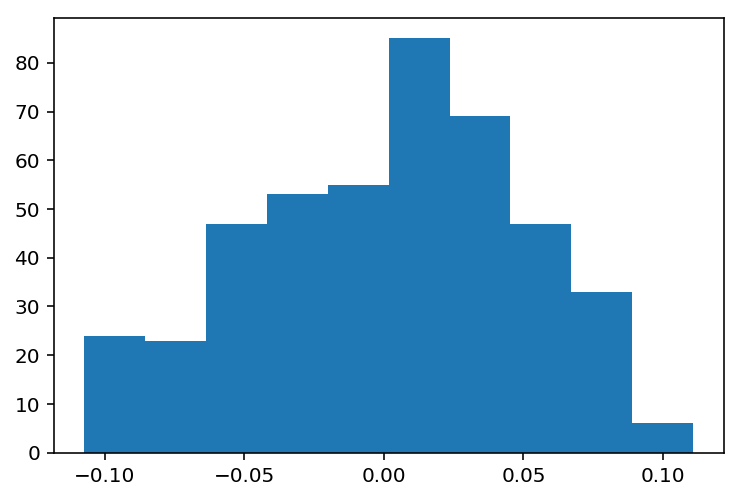

In [102]:
pl.hist(X.iloc[:,0])
pl.show()

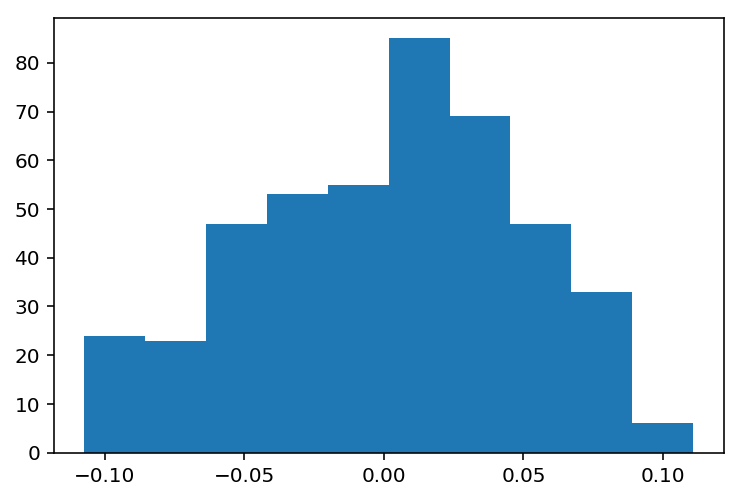

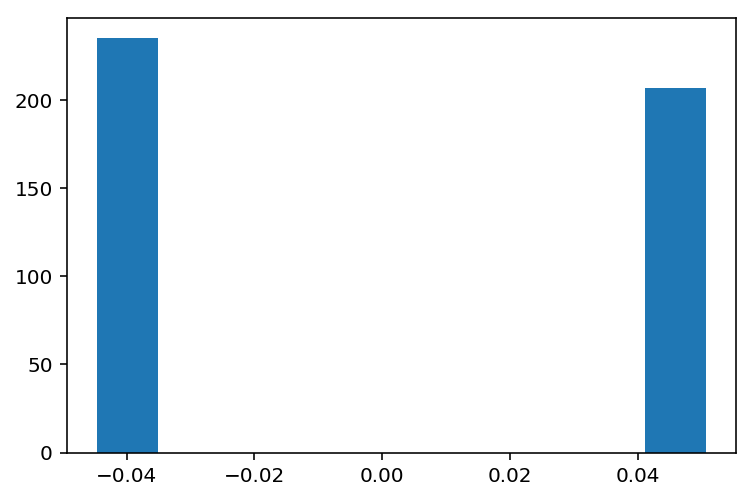

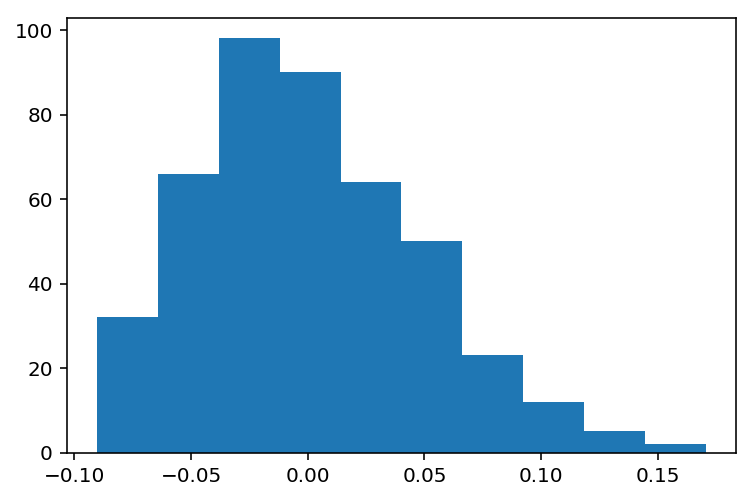

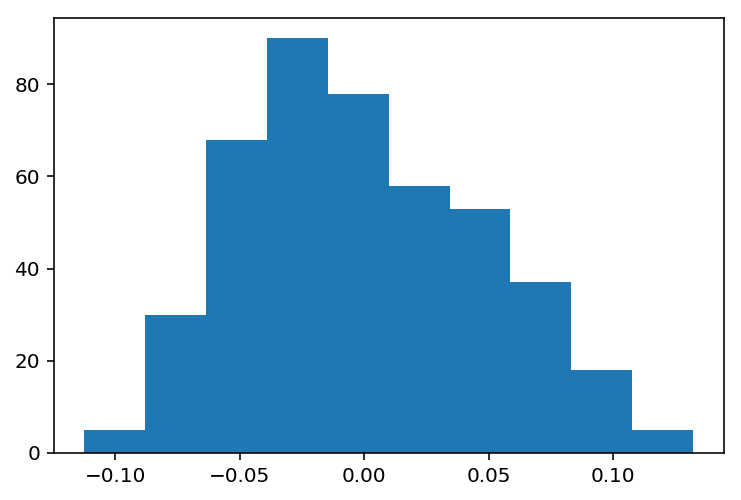

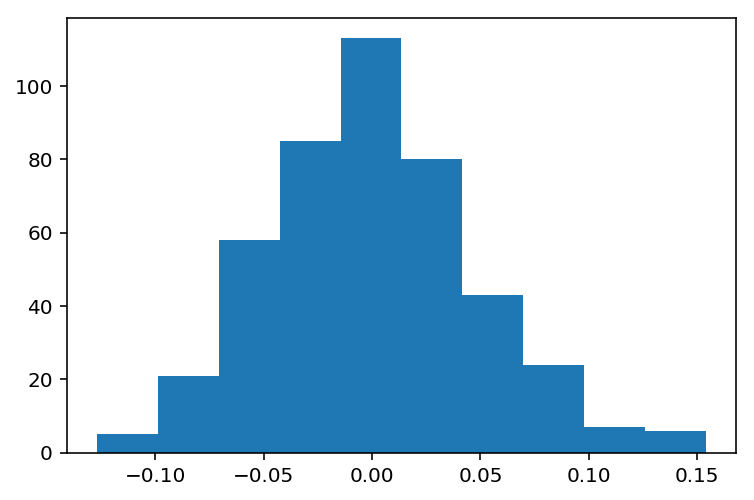

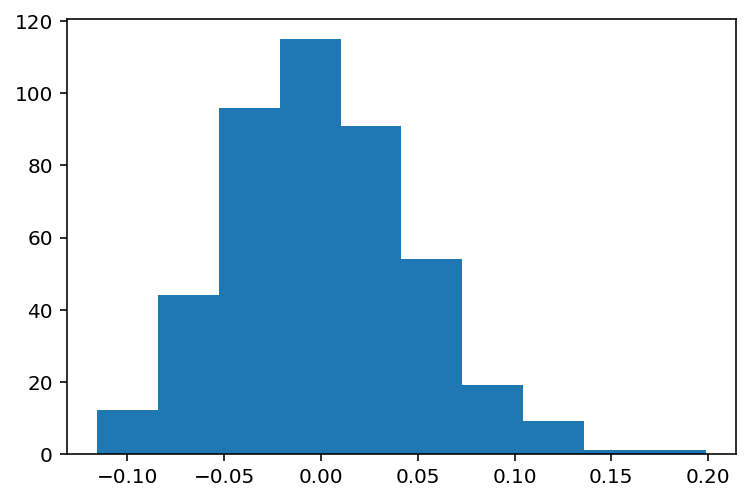

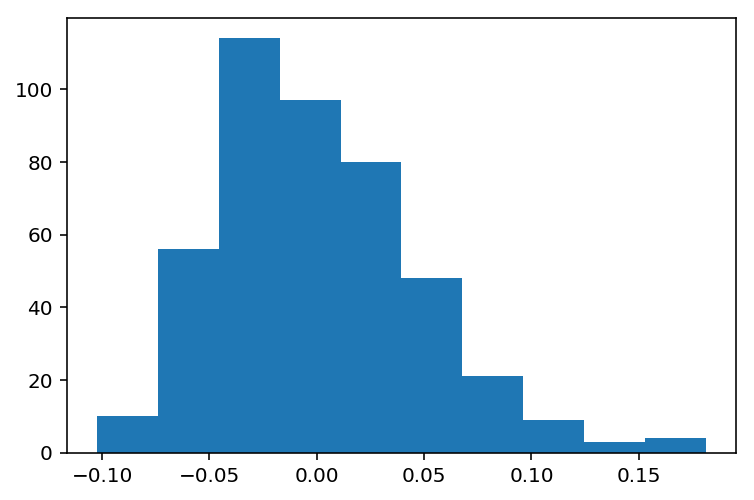

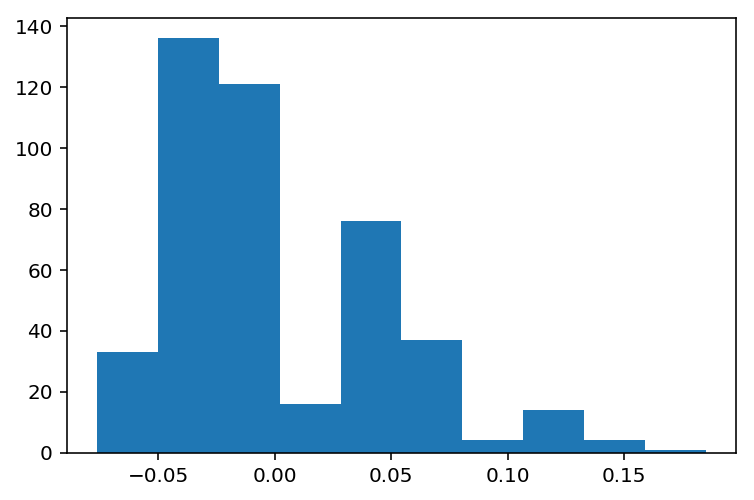

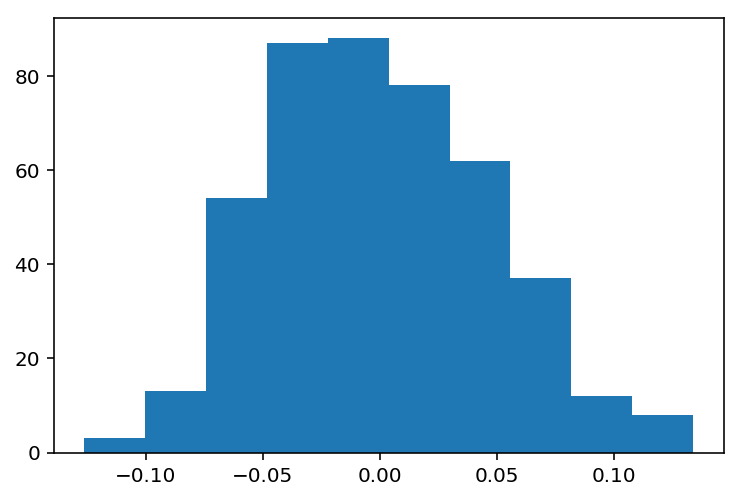

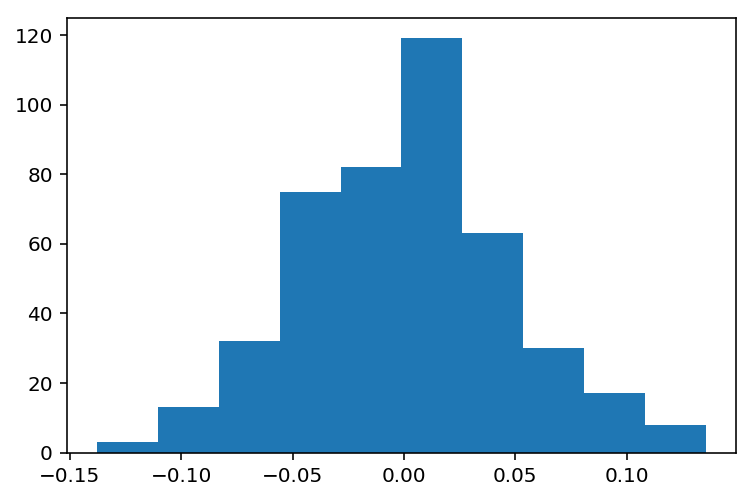

In [90]:
for i in range(X.shape[1]):
    pl.hist(X.iloc[:,i])
    pl.show()

In [18]:
shap.kmeans(X, 10)

In [47]:
shap.KernelExplainer(f, X).shap_values(X.iloc[0:1,:], nsamples=100000)

Using 442 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


array([[ 16.84847947,  -7.29603412,   2.95873035,  -3.82508003,
          8.20637047, -10.64156363,  -5.08293242,  -3.02311429,
         22.25346045,  -4.04896681, 152.11721854]])

In [128]:
shap.KernelExplainer(f, shap.kmeans(X, 5)).shap_values(X.iloc[0:1,:], nsamples=10040)

100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


array([[ 1.36868425e+01, -8.75395713e+00,  6.21583114e+00,
         1.05236702e-01,  8.08382021e+00, -1.35811009e+01,
        -8.94171606e+00,  2.73459672e+00,  1.71423095e+01,
         8.59150338e+00,  1.43183202e+02]])

In [129]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)

In [147]:
inds = np.arange(X.shape[0])
phi = np.zeros(X.shape[1]+1)
for i in range(1):
    np.random.shuffle(inds)
    phi += shap.KernelExplainer(f, X.iloc[inds[:1000],:]).shap_values(X.iloc[0,:], nsamples=10000)
phi / 1

array([ 16.84847947,  -7.29603412,   2.95873035,  -3.82508003,
         8.20637047, -10.64156363,  -5.08293242,  -3.02311429,
        22.25346045,  -4.04896681, 152.11721854])

In [146]:
inds = np.arange(X.shape[0])
phi = np.zeros(X.shape[1]+1)
for i in range(1000):
    np.random.shuffle(inds)
    phi += shap.KernelExplainer(f, X.iloc[inds[:1],:]).shap_values(X.iloc[0,:], nsamples=10000)
phi / 1000

array([ 14.9805967 ,  -7.13364173,  -2.87093182,  -3.37543416,
         9.57376501, -10.09240863,  -3.39216101,  -2.33921015,
        21.32924964,  -3.87312656, 155.65987069])

In [32]:
shap.KernelExplainer(f, X.iloc[inds[:1000],:]).shap_values(X.iloc[0:1,:], nsamples=500)

Using 1000 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 1/1 [02:19<00:00, 139.17s/it]


array([[-0.61679092,  0.        ,  0.        , -0.02424259,  0.        ,
         0.        ,  0.20657399,  0.        , -0.13817486,  0.        ,
         0.        , -0.05850959,  0.        ,  0.        ,  0.85548299]])

In [95]:

[ime(j, f, X.as_matrix()[0,:], X.as_matrix(), nsamples=1000) for j in range(X.shape[1])]

[-0.7165608,
 0.009631294,
 -0.0003004465,
 -0.0045051584,
 -0.0067957467,
 -0.002346974,
 0.10327559,
 0.05838719,
 -0.0405814,
 -0.013298897,
 0.0017015431,
 -0.01593088,
 0.0052840253,
 -0.00764299]

In [21]:
shap_values[0,:]

array([-1.4315891 ,  0.09290311,  0.00144139, -0.0416197 ,  0.01331905,
       -0.0220135 ,  0.5470503 ,  0.14953731, -0.19250727,  0.06781124,
        0.00730931, -0.07365462,  0.02795547, -0.00997558, -0.7068609 ],
      dtype=float32)

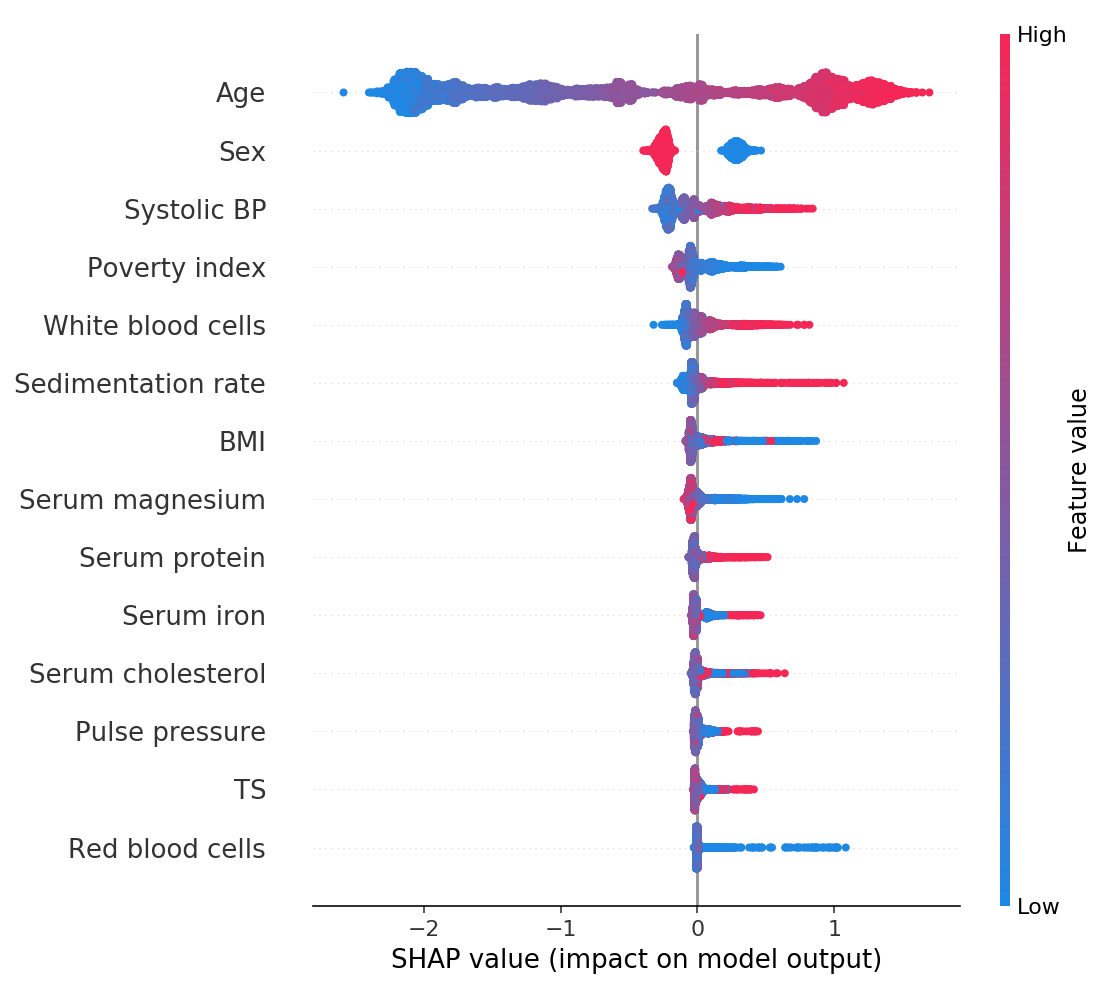

In [114]:
shap.summary_plot(shap_values, X, show=False)
pl.savefig("data/nhanes_summary.pdf", dpi=400)
pl.show()

In [7]:
# shap.summary_plot(shap_values, X, show=False)
# pl.gca().set_rasterized(True)
# pl.savefig("data/nhanes_summary.pdf", dpi=400)

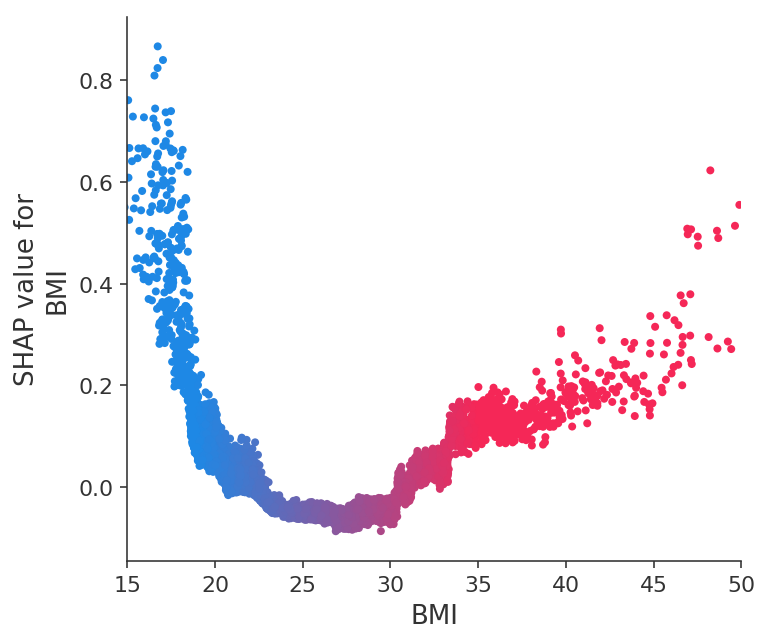

In [81]:
shap.dependence_plot("BMI", shap_values, X, show=False, interaction_index="BMI")
pl.xlim(15,50)
pl.gcf().set_size_inches(5.5, 5)
#pl.savefig("data/nhanes_bmi.pdf")
pl.show()

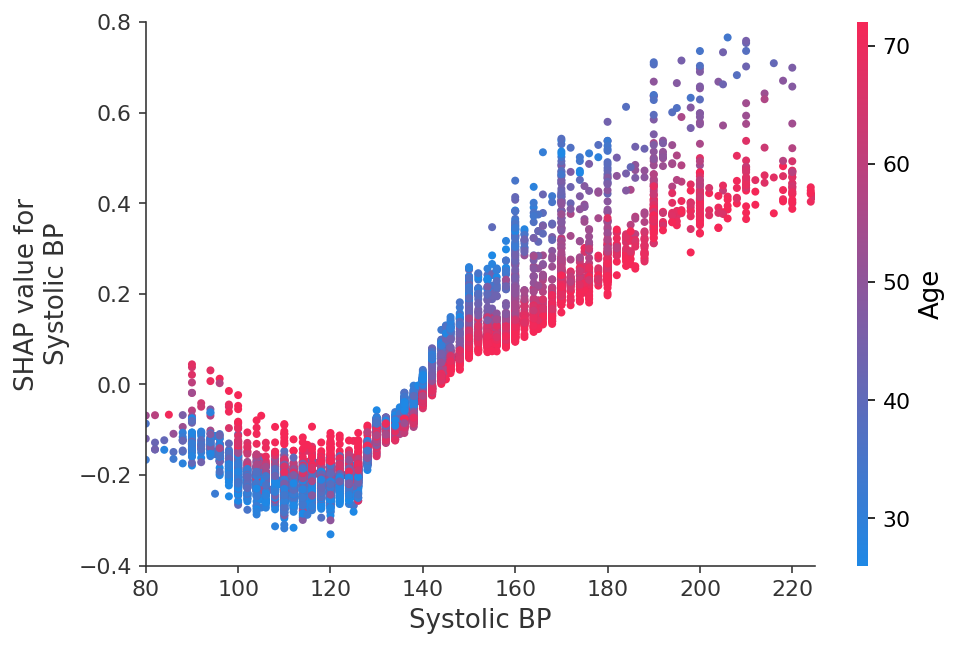

In [102]:
shap.dependence_plot("Systolic BP", shap_values, X, show=False)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.savefig("data/nhanes_sbp.pdf", dpi=400)
pl.show()

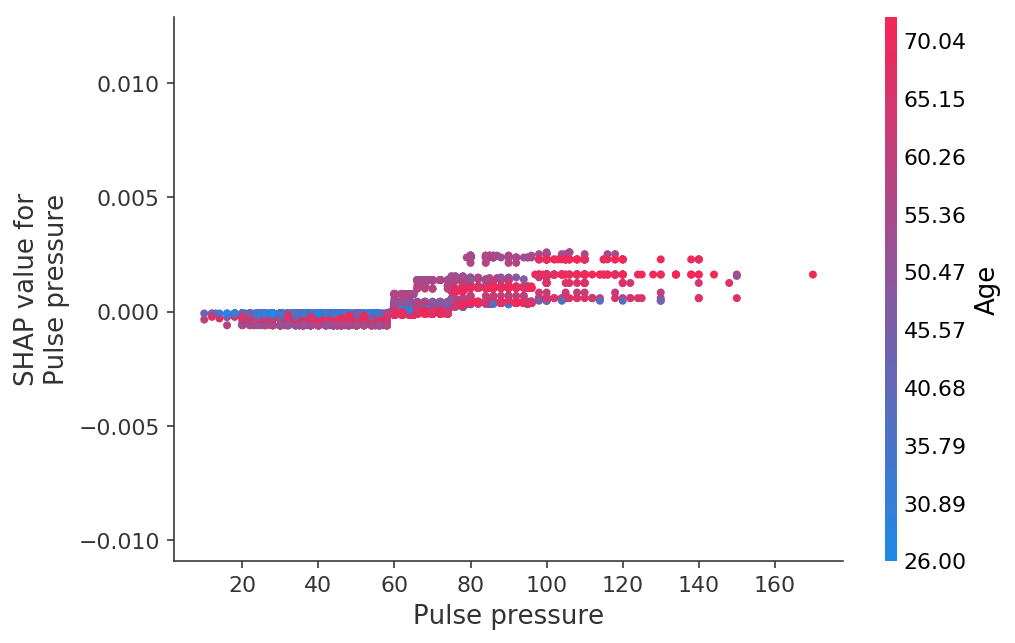

In [7]:
shap.dependence_plot("Pulse pressure", shap_values, X, show=False)
#pl.xlim(80,225)
# pl.savefig("data/nhanes_sbp.pdf")
# pl.show()

## Compute SHAP Interaction Values

In [91]:
start = time.time()
shap_interaction_values = model.predict(xgboost.DMatrix(X.iloc[:,:]), pred_interactions=True)
time.time() - start

1719.4832379817963

In [131]:
class IMEExplainer:
    """ This is an implementation of the IME explanation method (aka. Shapley sampling values)
    
    This is implemented here for comparision and evaluation purposes, the KernelExplainer is more
    typically more efficient and so is the preferred model agnostic estimation method in this package.
    IME was proposed in "An Efficient Explanation of Individual Classifications using Game Theory",
    Erik Štrumbelj, Igor Kononenko, JMLR 2010
    """
    
    def __init__(self, model, data, **kwargs):
        self.model = convert_to_model(model)
        self.keep_index = kwargs.get("keep_index", False)
        self.data = convert_to_data(data, keep_index=self.keep_index)
        match_model_to_data(self.model, self.data)
        
        # enforce our current input type limitations
        assert isinstance(self.data, DenseData), "Shap explainer only supports the DenseData input currently."
        assert not self.data.transposed, "Shap explainer does not support transposed DenseData currently."

        # init our parameters
        self.N = self.data.data.shape[0]
        self.P = self.data.data.shape[1]
        self.nsamplesAdded = 0
        self.nsamplesRun = 0
        
    def shap_values(self, X, **kwargs):
        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.as_matrix()
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            if self.keep_index:
                index_value = X.index.values
                index_name = X.index.name
                column_name = list(X.columns)
            X = X.as_matrix()

        assert str(type(X)).endswith("'numpy.ndarray'>"), "Unknown instance type: " + str(type(X))
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"
        
        # pick a reasonable number of samples if the user didn't specify how many they wanted
        nsamples = kwargs.get("nsamples", 0)
        if nsamples == 0:
            nsamples = 1000 * self.P
        
        # divide up the samples among the features
        nsamples_each = np.ones(self.P) * 2 * (nsamples // (self.P * 2))
        for i in range((nsamples % (self.P * 2)) // 2):
            nsamples_each[i] += 2
        
        # single instance
        if len(X.shape) == 1:
            data = X.reshape((1, X.shape[0]))
            if self.keep_index:
                data = convert_to_instance_with_index(data, column_name, index_name, index_value)
            explanation = self.explain(data, **kwargs)

            # vector-output
            s = explanation.effects.shape
            if len(s) == 2:
                outs = [np.zeros(s[0] + 1) for j in range(s[1])]
                for j in range(s[1]):
                    outs[j][:-1] = explanation.effects[:, j]
                    outs[j][-1] = explanation.base_value[j]
                return outs

            # single-output
            else:
                out = np.zeros(s[0] + 1)
                out[:-1] = explanation.effects
                out[-1] = explanation.base_value
                return out

        # explain the whole dataset
        elif len(X.shape) == 2:
            explanations = []
            for i in tqdm(range(X.shape[0])):
                data = X[i:i + 1, :]
                if self.keep_index:
                    data = convert_to_instance_with_index(data, column_name, index_value[i:i + 1], index_name)
                explanations.append(self.explain(data, **kwargs))

            # vector-output
            s = explanations[0].effects.shape
            if len(s) == 2:
                outs = [np.zeros((X.shape[0], s[0] + 1)) for j in range(s[1])]
                for i in range(X.shape[0]):
                    for j in range(s[1]):
                        outs[j][i, :-1] = explanations[i].effects[:, j]
                        outs[j][i, -1] = explanations[i].base_value[j]
                return outs

            # single-output
            else:
                out = np.zeros((X.shape[0], s[0] + 1))
                for i in range(X.shape[0]):
                    out[i, :-1] = explanations[i].effects
                    out[i, -1] = explanations[i].base_value
                return out
        
        
    def ime(j, f, x, X, nsamples=10):
        assert nsamples % 2 == 0, "nsamples must be divisible by 2!"

        X_masked = np.zeros((nsamples, X.shape[1]))
        inds = np.arange(X.shape[1])

        for i in range(0, nsamples//2):
            pos = np.where(inds == j)[0][0]
            rind = np.random.randint(X.shape[0])
            X_masked[i,:] = x
            X_masked[i,inds[pos+1:]] = X[rind,inds[pos+1:]]
    #         print(i)
    #         print(-(i+1))
            X_masked[-(i+1),:] = x
            X_masked[-(i+1),inds[pos:]] = X[rind,inds[pos:]]
    #     print(X_masked)
        evals = f(X_masked)
        return np.mean(evals[:nsamples//2] - evals[nsamples//2:])
    
        

In [56]:
np.exp(pred[i]),np.exp(pred[i:]).sum()

(1.5835168, 16780.945)

In [57]:
pred

array([ 0.4273698 ,  0.69642174,  0.69901985, ...,  0.42367142,
        0.50241035,  0.7435447 ], dtype=float32)

In [62]:
?np.sort

[<matplotlib.lines.Line2D at 0x1a27189e48>]

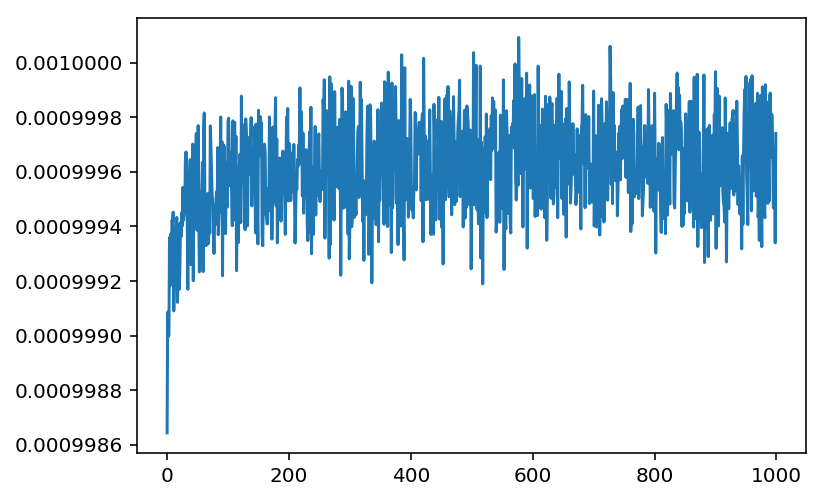

In [75]:
pred = model.predict(xgb_full, output_margin=True)
pred = np.flip(np.sort(pred),axis=0)
C = 0.001
tmp = [np.log(np.exp(pred[i]+C)/(np.exp(pred[i+1:]).sum() + np.exp(pred[i]+C))) - np.log(np.exp(pred[i])/np.exp(pred[i:]).sum()) for i in range(1000)]
pl.plot(tmp)

In [ ]:
def scaled(A, B, C):
    return A*C/(B + A*C)

In [41]:
B = 100
C = 0.01
out = np.zeros(100)
proportion = np.zeros(100)
As = np.linspace(-20,20,100)
for i,A in enumerate(As):
    proportion[i] = np.exp(A)/(B+np.exp(A))
    out[i] = A + C - np.log(B + np.exp(A)*np.exp(C)) - (A - np.log(B + np.exp(A)))

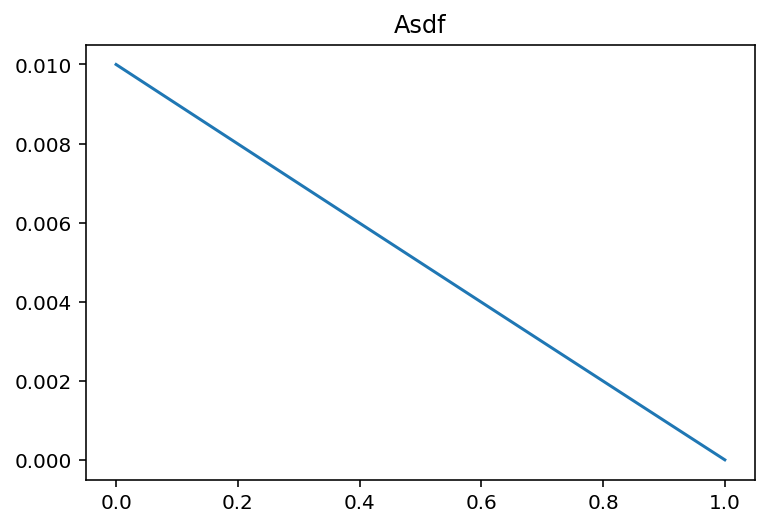

In [42]:
pl.plot(proportion,out)
pl.title("Asdf")

[<matplotlib.lines.Line2D at 0x1a1fbf29e8>]

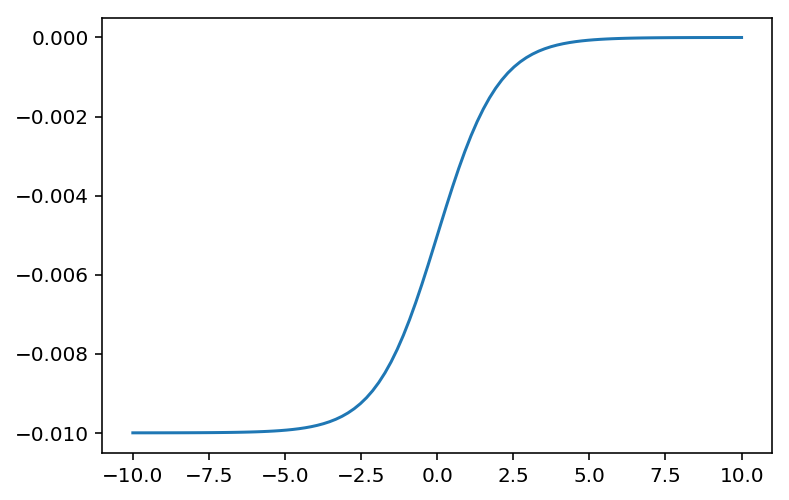

In [43]:
xs = np.linspace(-10,10,100)
pl.plot(xs, np.log(1/(1+np.exp(-xs+C))) - np.log(1/(1+np.exp(-xs))))

In [ ]:
np.log(1) - np.log(1+np.exp(-xs+C))

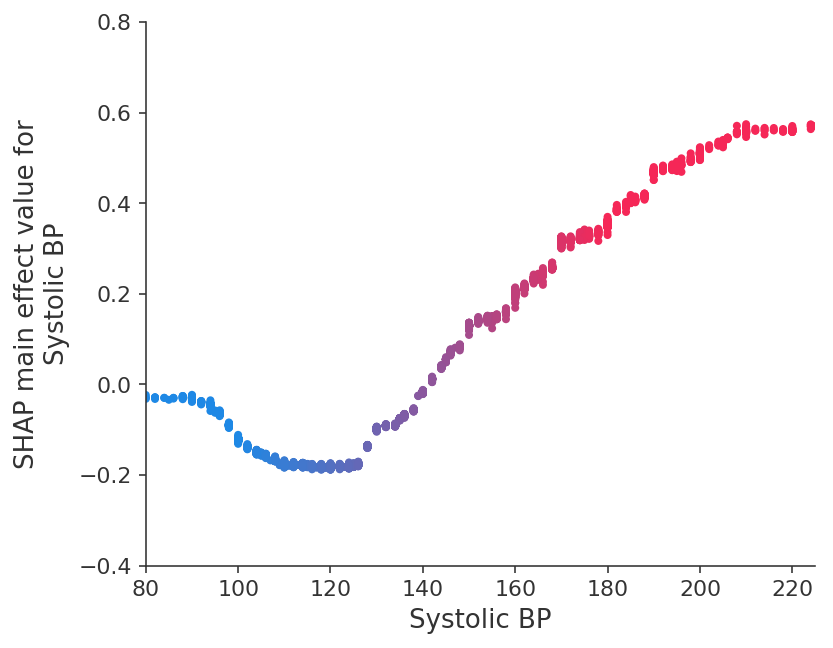

In [104]:
shap.dependence_plot(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X_display.iloc[:,:],
    show=False
)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.ylabel("SHAP main effect value for\nSystolic BP")
pl.gcf().set_size_inches(6, 5)
pl.savefig("data/nhanes_sbp_main_effect.pdf", dpi=400)
pl.show()

In [111]:
def dependence_plot2(ind, shap_values, features, feature_names=None, display_features=None,
                    interaction_index="auto", color="#ff0052", axis_color="#333333",
                    dot_size=16, alpha=1, title=None, show=True):
    """
    Create a SHAP dependence plot, colored by an interaction feature.

    Parameters
    ----------
    ind : int
        Index of the feature to plot.

    shap_values : numpy.array
        Matrix of SHAP values (# samples x # features)

    features : numpy.array or pandas.DataFrame
        Matrix of feature values (# samples x # features)

    feature_names : list
        Names of the features (length # features)

    display_features : numpy.array or pandas.DataFrame
        Matrix of feature values for visual display (such as strings instead of coded values)

    interaction_index : "auto", None, or int
        The index of the feature used to color the plot.
    """

    # convert from DataFrames if we got any
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        features = features.as_matrix()
    if str(type(display_features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = display_features.columns
        display_features = display_features.as_matrix()
    elif display_features is None:
        display_features = features

    if feature_names is None:
        feature_names = ["Feature "+str(i) for i in range(shap_values.shape[1]-1)]

    # allow vectors to be passed
    if len(shap_values.shape) == 1:
        shap_values = np.reshape(shap_values, len(shap_values), 1)
    if len(features.shape) == 1:
        features = np.reshape(features, len(features), 1)

    def convert_name(ind):
        if type(ind) == str:
            nzinds = np.where(feature_names == ind)[0]
            if len(nzinds) == 0:
                print("Could not find feature named: "+ind)
                return None
            else:
                return nzinds[0]
        else:
            return ind

    ind = convert_name(ind)

    # plotting SHAP interaction values
    if len(shap_values.shape) == 3 and len(ind) == 2:
        ind1 = convert_name(ind[0])
        ind2 = convert_name(ind[1])
        if ind1 == ind2:
            proj_shap_values = shap_values[:,ind2,:]
        else:
            proj_shap_values = shap_values[:,ind2,:] * 2 # off-diag values are split in half
        dependence_plot2(
            ind1, proj_shap_values, features, feature_names=feature_names,
            interaction_index=ind2, display_features=display_features, show=False
        )
        if ind1 == ind2:
            pl.ylabel("SHAP main effect value for\n"+feature_names[ind1])
        else:
            pl.ylabel("SHAP interaction value for\n"+feature_names[ind1]+" and "+feature_names[ind2])

        if show:
            pl.show()
        return

    # get both the raw and display feature values
    xv = features[:,ind]
    xd = display_features[:,ind]
    s = shap_values[:,ind]
    if type(xd[0]) == str:
        name_map = {}
        for i in range(len(xv)):
            name_map[xd[i]] = xv[i]
        xnames = list(name_map.keys())

    # allow a single feature name to be passed alone
    if type(feature_names) == str:
        feature_names = [feature_names]
    name = feature_names[ind]

    # guess what other feature as the stongest interaction with the plotted feature
    if interaction_index == "auto":
        interaction_index = approx_interactions(ind, shap_values, features)[0]
    interaction_index = convert_name(interaction_index)

    # get both the raw and display color values
    cv = features[:,interaction_index]
    cd = display_features[:,interaction_index]
    categorical_interaction = False
    clow = np.nanpercentile(features[:,interaction_index], 5)
    chigh = np.nanpercentile(features[:,interaction_index], 95)
    if type(cd[0]) == str:
        cname_map = {}
        for i in range(len(cv)):
            cname_map[cd[i]] = cv[i]
        cnames = list(cname_map.keys())
        categorical_interaction = True
    elif clow % 1 == 0 and chigh % 1 == 0 and len(set(features[:,interaction_index])) < 50:
        categorical_interaction = True

    # discritize colors for categorical features
    color_norm = None
    if categorical_interaction and clow != chigh:
        bounds = np.linspace(clow, chigh, chigh-clow+2)
        color_norm = matplotlib.colors.BoundaryNorm(bounds, red_blue.N)

    # the actual scatter plot, TODO: adapt the dot_size to the number of data points?
    pl.scatter(xv, s, s=dot_size, linewidth=0, c="#1E88E5",
               alpha=alpha, rasterized=len(xv) > 500)

    if interaction_index != ind:
        # draw the color bar
        norm = None
        if type(cd[0]) == str:
            tick_positions = [cname_map[n] for n in cnames]
            if len(tick_positions) == 2:
                tick_positions[0] -= 0.25
                tick_positions[1] += 0.25
            cb = pl.colorbar(ticks=tick_positions)
            cb.set_ticklabels(cnames)

        else:
            cb = pl.colorbar()
        cb.set_label(feature_names[interaction_index], size=13)
        cb.ax.tick_params(labelsize=11)
        if categorical_interaction:
            cb.ax.tick_params(length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)
        bbox = cb.ax.get_window_extent().transformed(pl.gcf().dpi_scale_trans.inverted())
        cb.ax.set_aspect((bbox.height-0.7)*20)

    # make the plot more readable
    if interaction_index != ind:
        pl.gcf().set_size_inches(7.5, 5)
    else:
        pl.gcf().set_size_inches(6, 5)
    pl.xlabel(name, color=axis_color, fontsize=13)
    pl.ylabel("SHAP value for\n"+name, color=axis_color, fontsize=13)
    if title != None:
        pl.title(title, color=axis_color, fontsize=13)
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('left')
    pl.gca().spines['right'].set_visible(False)
    pl.gca().spines['top'].set_visible(False)
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color, labelsize=11)
    for spine in pl.gca().spines.values():
        spine.set_edgecolor(axis_color)
    if type(xd[0]) == str:
        pl.xticks([name_map[n] for n in xnames], xnames, rotation='vertical', fontsize=11)
    if show:
        pl.show()


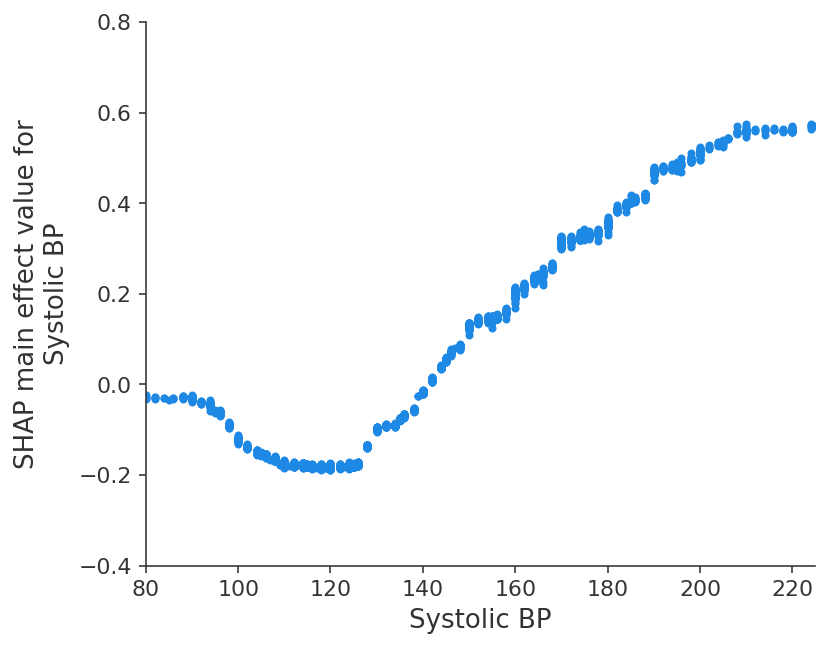

In [112]:
dependence_plot2(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X_display.iloc[:,:],
    show=False
)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.ylabel("SHAP main effect value for\nSystolic BP")
pl.gcf().set_size_inches(6, 5)
pl.savefig("data/nhanes_sbp_main_effect.pdf", dpi=400)
pl.show()

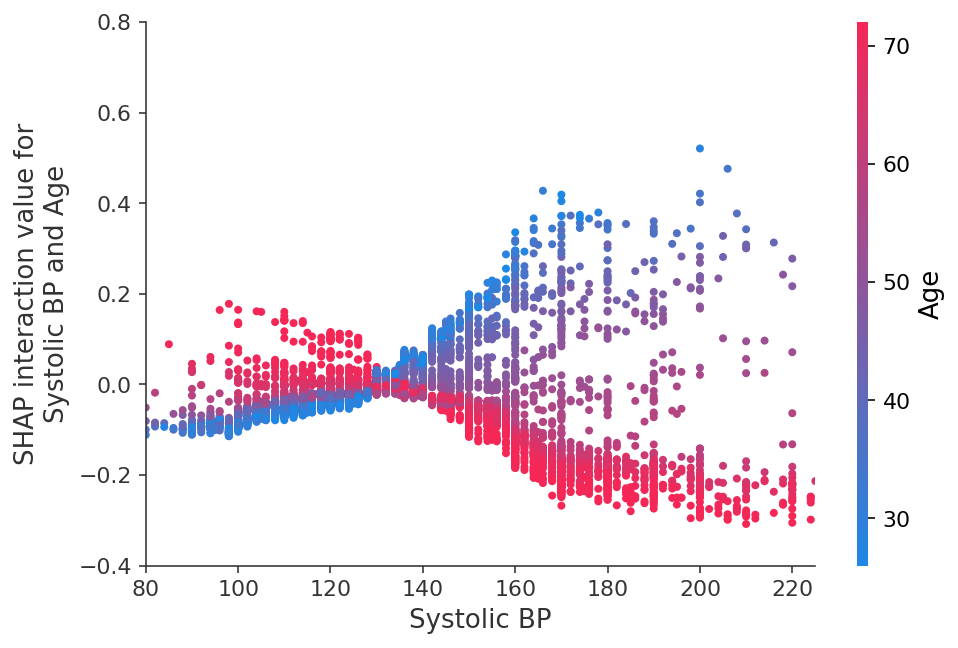

In [100]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X_display.iloc[:,:],
    show=False
)
pl.xlim(80,225)
pl.ylim(-0.4,0.8)
pl.savefig("data/nhanes_sbp_age_interaction.pdf", dpi=400)
pl.show()

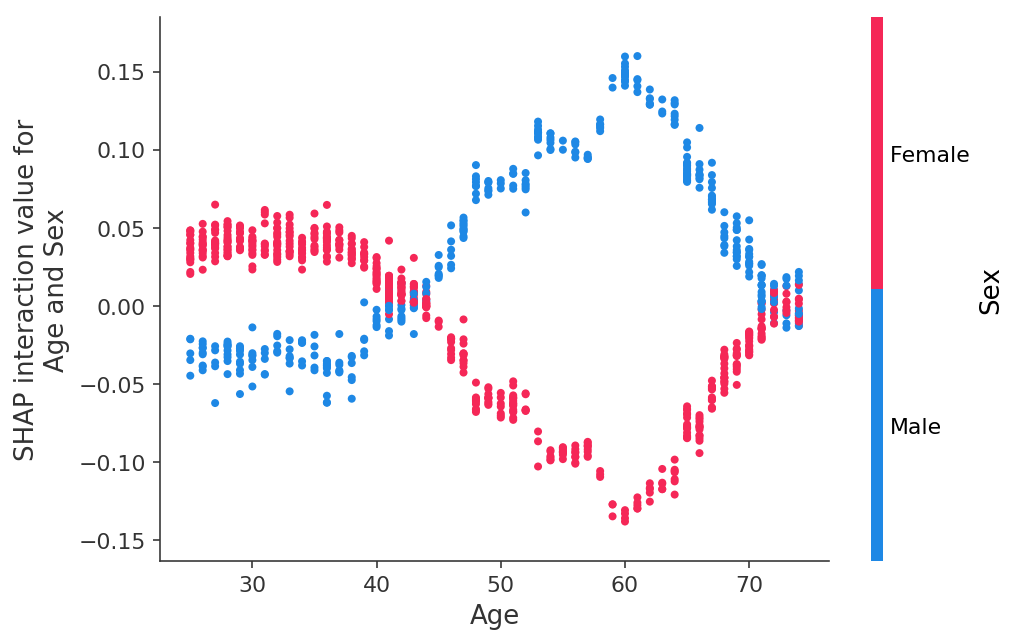

In [5]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X.iloc[:1000,:],
    display_features=X_display.iloc[:1000,:]
)

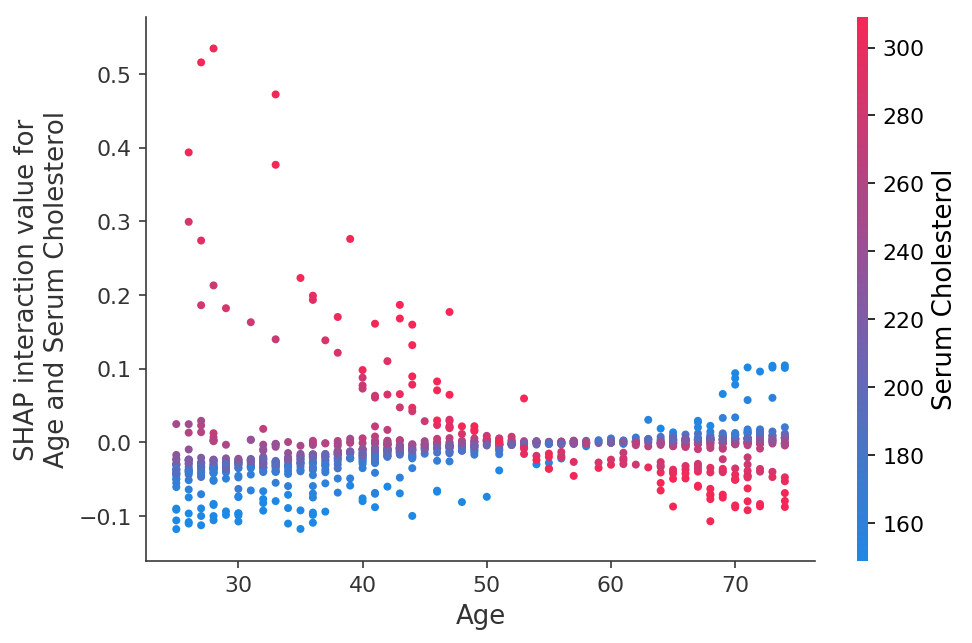

In [56]:
shap.dependence_plot(0, shap_interaction_values[:,4,:], X.iloc[:1000,:], interaction_index=4, show=False)
pl.ylabel("SHAP interaction value for\nAge and Serum Cholesterol")
pl.show()

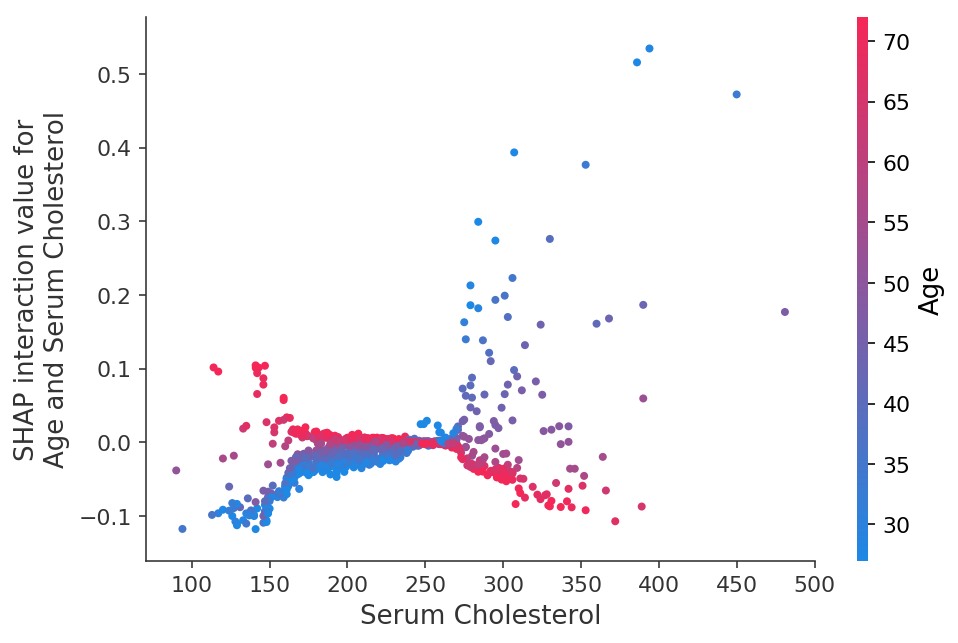

In [58]:
shap.dependence_plot(4, shap_interaction_values[:,0,:], X.iloc[:1000,:], interaction_index=0, show=False)
pl.ylabel("SHAP interaction value for\nAge and Serum Cholesterol")
pl.show()

In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[:,:-1])

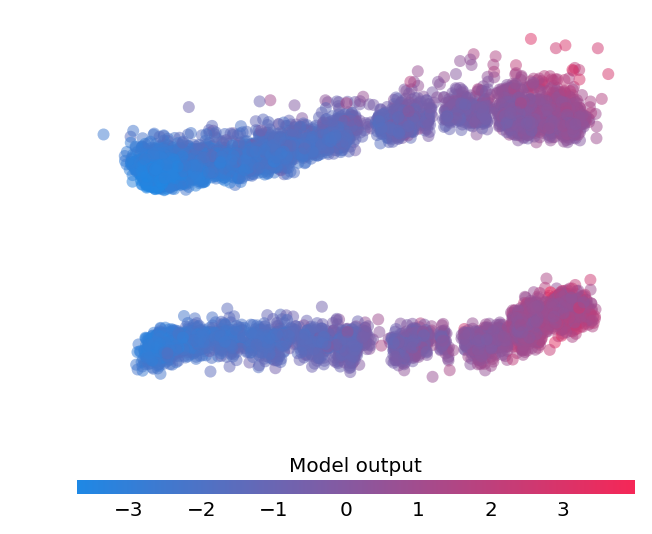

In [13]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=np.sum(shap_values,axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

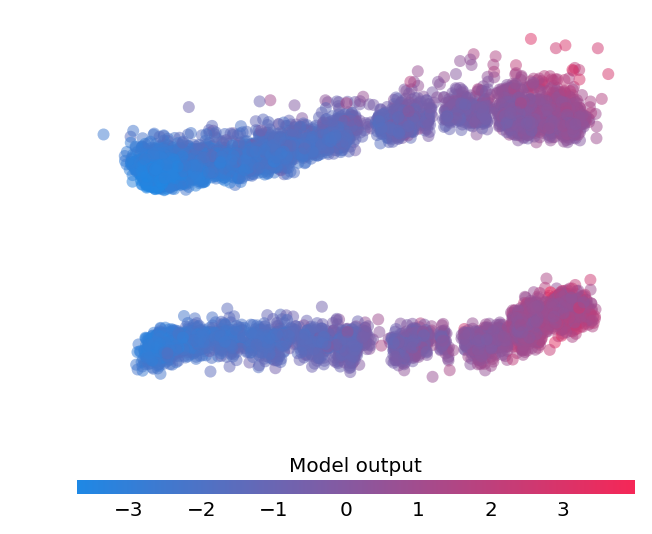

In [13]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=np.sum(shap_values,axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

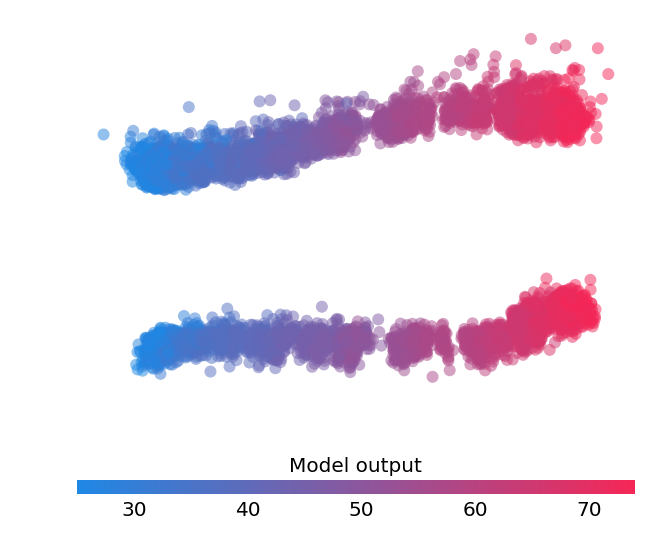

In [23]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=X["Age"], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

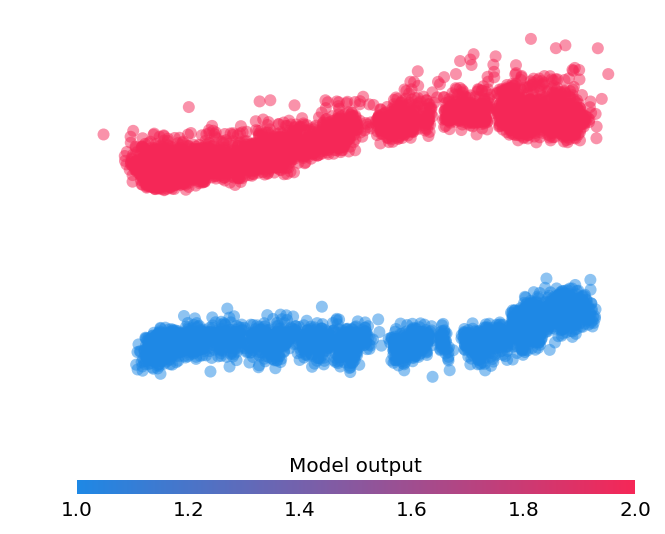

In [24]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=X["Sex"], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

In [15]:
shap_pca2 = PCA(n_components=2).fit(shap_values[:,:-1])

In [17]:
?shap_pca2

In [19]:
shap_pca2.components_.round(2)

array([[ 1.        ,  0.01      ,  0.        ,  0.01      ,  0.        ,
        -0.        ,  0.        ,  0.        ,  0.04      ,  0.07      ,
        -0.        , -0.        , -0.        , -0.        ],
       [ 0.03      ,  0.05      ,  0.01      ,  0.09      ,  0.        ,
         0.01      ,  0.03      ,  0.        , -0.99000001,  0.02      ,
         0.01      , -0.02      ,  0.05      ,  0.01      ]], dtype=float32)

In [39]:
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:-1])

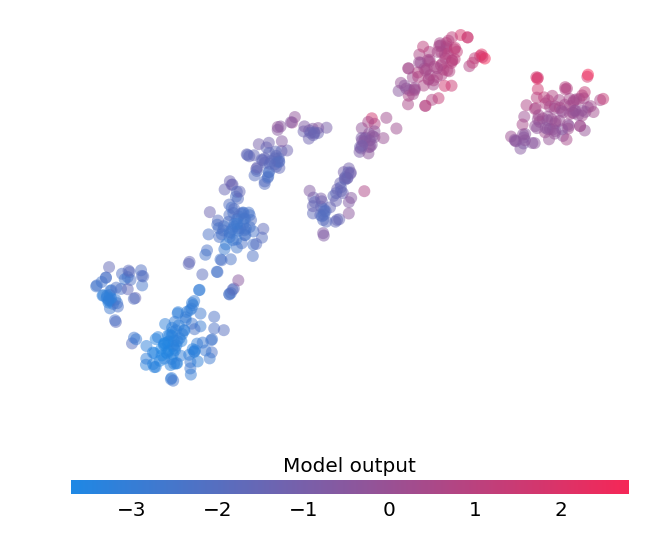

In [32]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=np.sum(shap_values[:1000,:],axis=1), linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

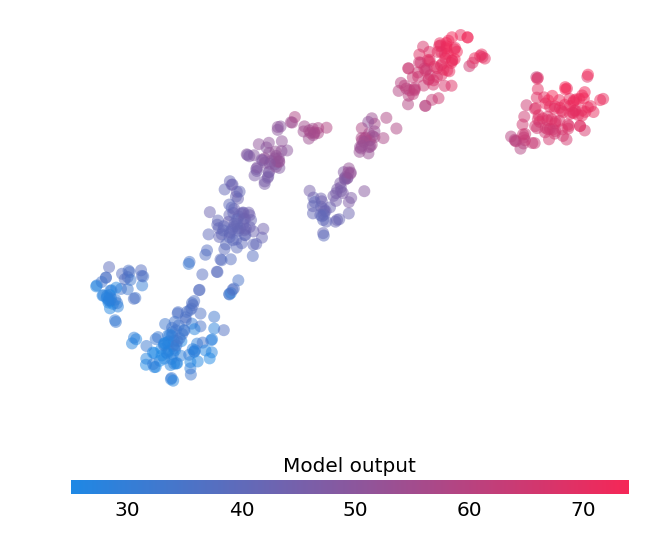

In [34]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X["Age"][:1000], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

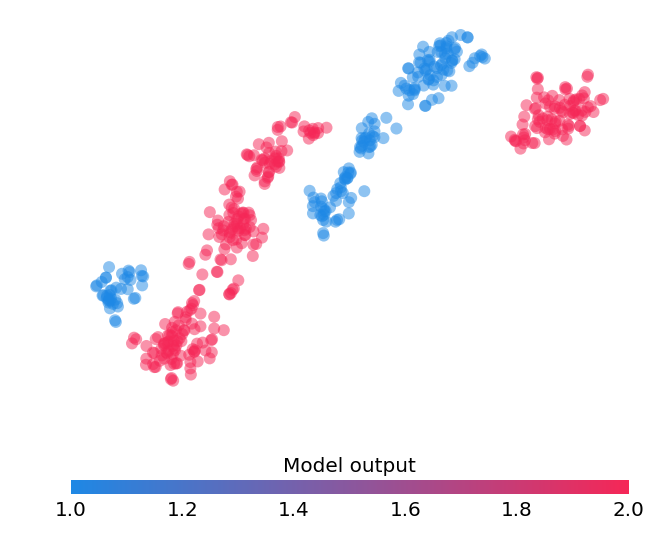

In [35]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X["Sex"][:500], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

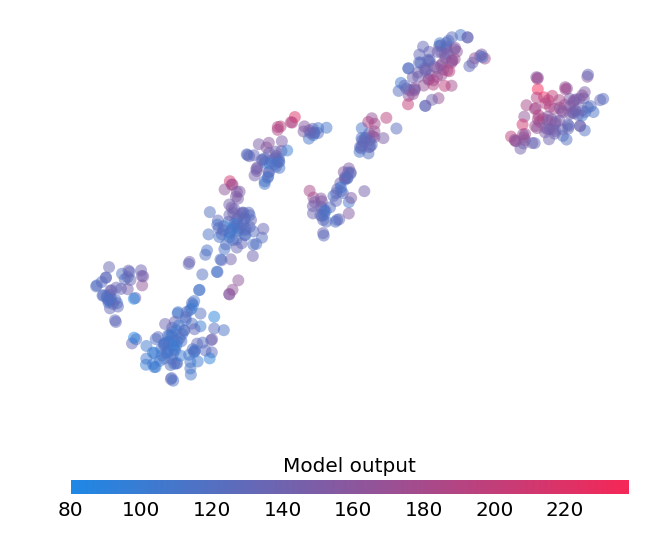

In [36]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0], shap_embedded[:,1], c=X["Systolic BP"][:500], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()

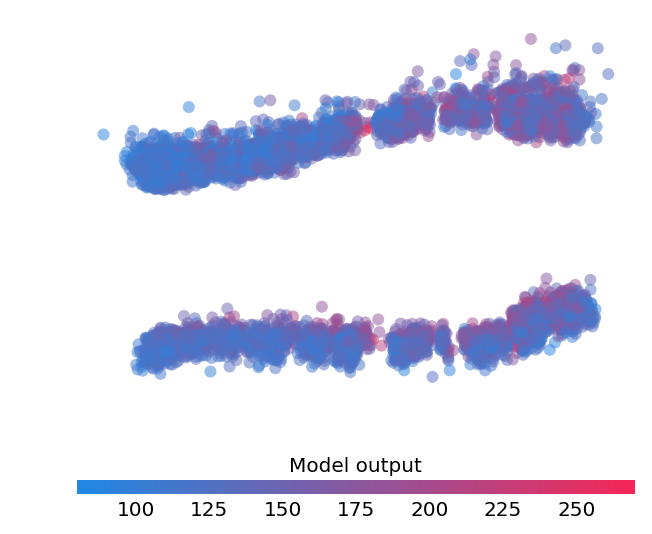

In [38]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_pca2[:,0], shap_pca2[:,1], c=X["Systolic BP"], linewidth=0, alpha=0.5, cmap=shap.plots.red_blue)
cb = pl.colorbar(label="Model output", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()